#PASO 1 — Limpieza y organización

In [ ]:
import pandas as pd

# Ruta del archivo cargado en Google Colab
ruta = "/content/PM TOTALES CU2.xlsx"  # Make sure to upload 'PM TOTALES CU.xlsx' to the '/content/' directory in Colab
df = pd.read_excel(ruta)

# Renombrar columnas principales
df.columns = [col.strip() for col in df.columns]
df.columns.values[0:2] = ['CU', 'CARRERA']

# Eliminar filas completamente vacías
df.dropna(how='all', inplace=True)

# Derretir columnas por periodo
value_vars = df.columns[2:]
df_melted = df.melt(id_vars=["CU", "CARRERA"], value_vars=value_vars,
                    var_name="PERIODO_TIPO", value_name="VALOR")

# Separar PERIODO y TIPO (AS, AD, PM)
df_melted[['PERIODO', 'TIPO']] = df_melted['PERIODO_TIPO'].str.extract(r'(\d{4}[AB])\s+(\w+)', expand=True)

# Reorganizar a columnas normales
df_limpio = df_melted.pivot_table(
    index=["CU", "CARRERA", "PERIODO"], columns="TIPO", values="VALOR", aggfunc='first'
).reset_index()

In [ ]:
# Renombrar columnas
df_limpio = df_limpio.rename(columns={"AS": "ASPIRANTES", "AD": "ADMITIDOS", "PM": "PUNTAJE_MINIMO"})

# Extraer año y ciclo
df_limpio["AÑO"] = df_limpio["PERIODO"].str.extract(r'(\d{4})').astype(int)
df_limpio["CICLO"] = df_limpio["PERIODO"].str.extract(r'([AB])')

# Convertir a valores numéricos
for col in ["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]:
    df_limpio[col] = pd.to_numeric(df_limpio[col], errors="coerce")

# Limpiar texto
df_limpio["CU"] = df_limpio["CU"].astype(str).str.strip().str.upper()
df_limpio["CARRERA"] = df_limpio["CARRERA"].astype(str).str.strip().str.upper()

# Copia principal de trabajo
df_carreras = df_limpio.copy()


In [ ]:
# Tasa de Demanda (TD) y Tasa de Admisión (TA)
df_carreras["TASA_DEMANDA"] = df_carreras["ASPIRANTES"] / df_carreras["ADMITIDOS"]
df_carreras["TASA_ADMISION"] = df_carreras["ADMITIDOS"] / df_carreras["ASPIRANTES"]

# Ordenar para cálculo de variaciones
df_carreras.sort_values(["CARRERA", "PERIODO"], inplace=True)

# Cambio porcentual de aspirantes por carrera
df_carreras["CAMBIO_ASPIRANTES"] = df_carreras.groupby("CARRERA")["ASPIRANTES"].pct_change()


In [ ]:
df_ciclo_A = df_carreras[df_carreras["CICLO"] == "A"].copy()
df_ciclo_B = df_carreras[df_carreras["CICLO"] == "B"].copy()


In [ ]:
# Preparar datos con pesos (admitidos)
df_peso = df_carreras[["CU", "PERIODO", "PUNTAJE_MINIMO", "ADMITIDOS"]].dropna()
df_peso["PESO"] = df_peso["ADMITIDOS"]

# Función de ponderación
def calcular_ponderado(grupo):
    puntaje_pond = (grupo["PUNTAJE_MINIMO"] * grupo["PESO"]).sum() / grupo["PESO"].sum()
    return pd.Series({"PUNTAJE_MINIMO": puntaje_pond})

# DataFrame de resumen por CU y periodo
df_resumen_cu = (
    df_peso.groupby(["CU", "PERIODO"], group_keys=False)[["PUNTAJE_MINIMO", "PESO"]]
    .apply(calcular_ponderado)
    .reset_index()
)


#PASO 2 — Exploración y visualizaciones avanzadas (EDA)

Descripcion....

##🟦 SECCIÓN 1. Comparativas temporales y globales

1.1 Tendencia general de aspirantes por año y CU

🎯 Objetivo:
Visualizar cómo ha cambiado el número de aspirantes a lo largo del tiempo en cada centro universitario (CU), lo cual refleja el nivel de interés global.

📈 Tipo de gráfico:
Línea múltiple (una línea por CU)

📋 Variables clave:
* AÑO
* ASPIRANTES
* CU

🔎 ¿Qué revela?:
Permite identificar qué centros han ganado o perdido popularidad con el tiempo.

Este gráfico revela la evolución del interés estudiantil en los diferentes centros universitarios de la UDG entre 2003 y 2024. Las líneas representan el número de aspirantes año con año, diferenciando cada CU.



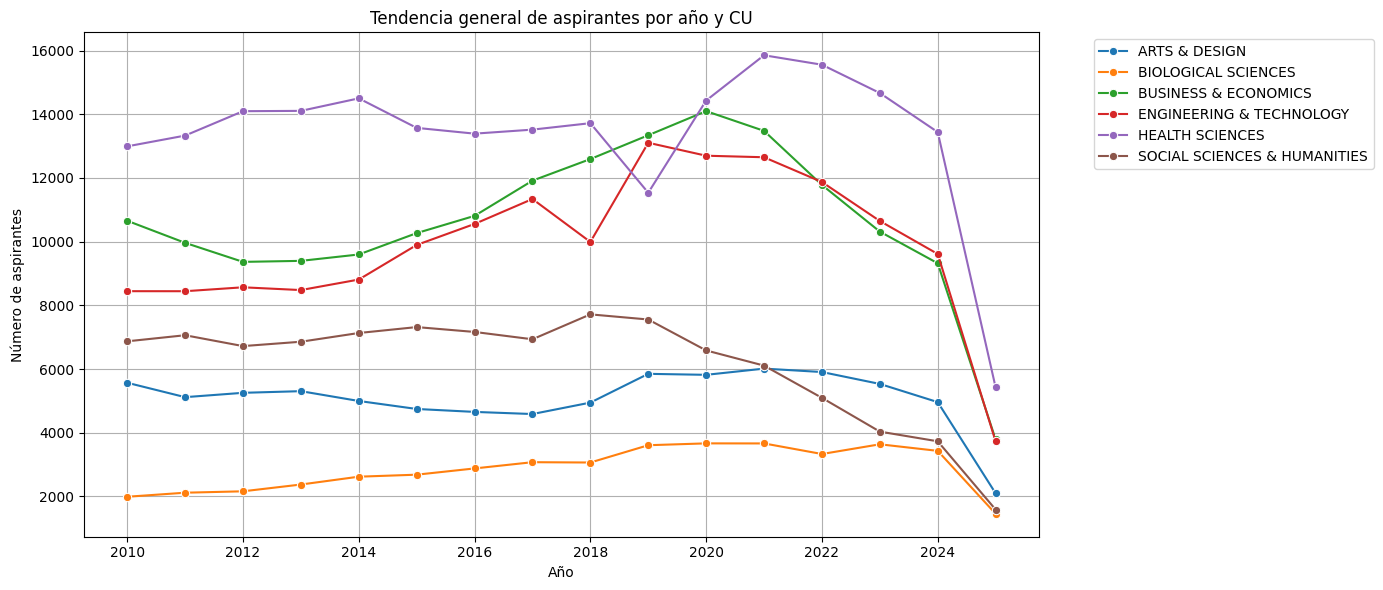

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por CU y AÑO, sumando aspirantes por centro y año
aspirantes_cu_anio = df_carreras.groupby(['CU', 'AÑO'])['ASPIRANTES'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=aspirantes_cu_anio, x='AÑO', y='ASPIRANTES', hue='CU', marker="o")
plt.title("Tendencia general de aspirantes por año y CU")
plt.ylabel("Número de aspirantes")
plt.xlabel("Año")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1.2 Puntaje mínimo por CU a lo largo del tiempo

🎯 Objetivo:
Mostrar cómo ha evolucionado el puntaje mínimo requerido en cada CU a lo largo del tiempo.

📈 Tipo de gráfico:
Línea múltiple (una línea por CU)

📋 Variables clave:
* AÑO
* PUNTAJE_MINIMO
* CU

🔎 ¿Qué revela?:
Indica en qué centros ha aumentado o disminuido la dificultad de ingreso.

Este gráfico muestra los cambios en el puntaje mínimo de ingreso por CU entre 2003 y 2024. Un aumento constante puede reflejar una mayor competitividad.

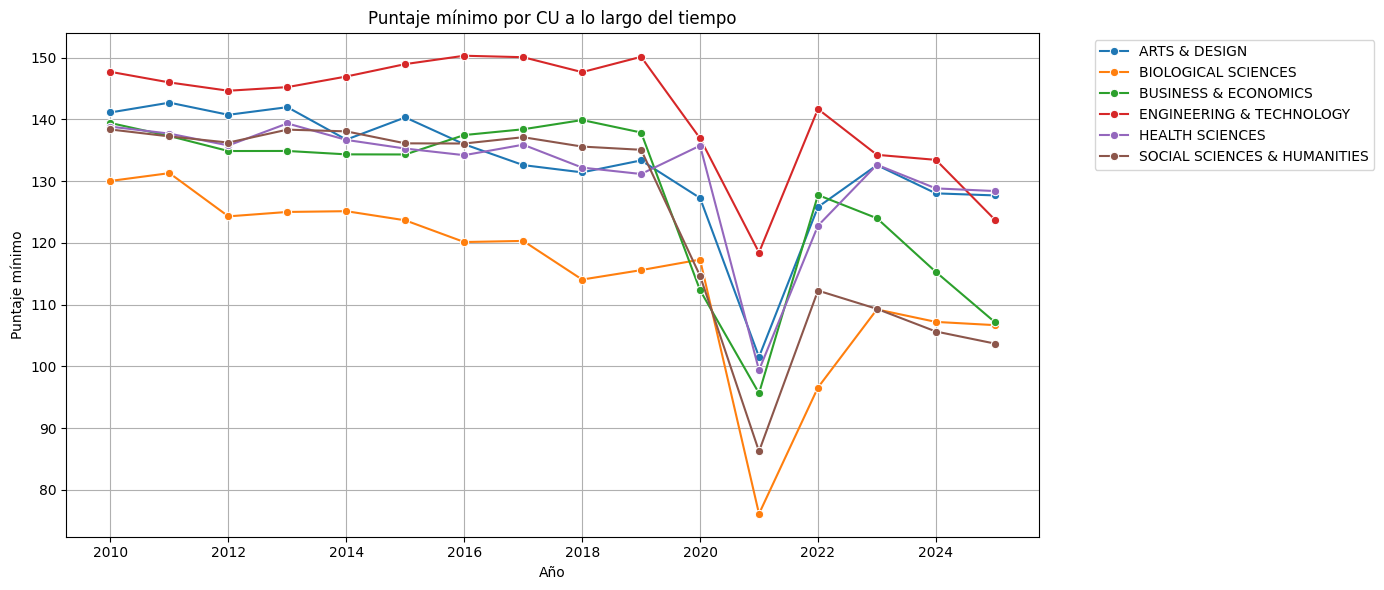

In [ ]:
# Agrupar por CU y AÑO, calculando el promedio de puntaje mínimo
pm_cu_anio = df_carreras.groupby(['CU', 'AÑO'])['PUNTAJE_MINIMO'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=pm_cu_anio, x='AÑO', y='PUNTAJE_MINIMO', hue='CU', marker="o")
plt.title("Puntaje mínimo por CU a lo largo del tiempo")
plt.ylabel("Puntaje mínimo")
plt.xlabel("Año")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



1.3 Aspirantes vs Admitidos por año (total general)

🎯 Objetivo:
Comparar la demanda total contra la oferta total de lugares a lo largo del tiempo.

📈 Tipo de gráfico:
Barras agrupadas

📋 Variables clave:
* AÑO
* ASPIRANTES
* ADMITIDOS

🔎 ¿Qué revela?:
Cuánto de la demanda está siendo cubierta por la oferta cada año.

Esta gráfica permite comparar el número de aspirantes y admitidos en cada año, evidenciando posibles déficits o ajustes en la capacidad de ingreso.



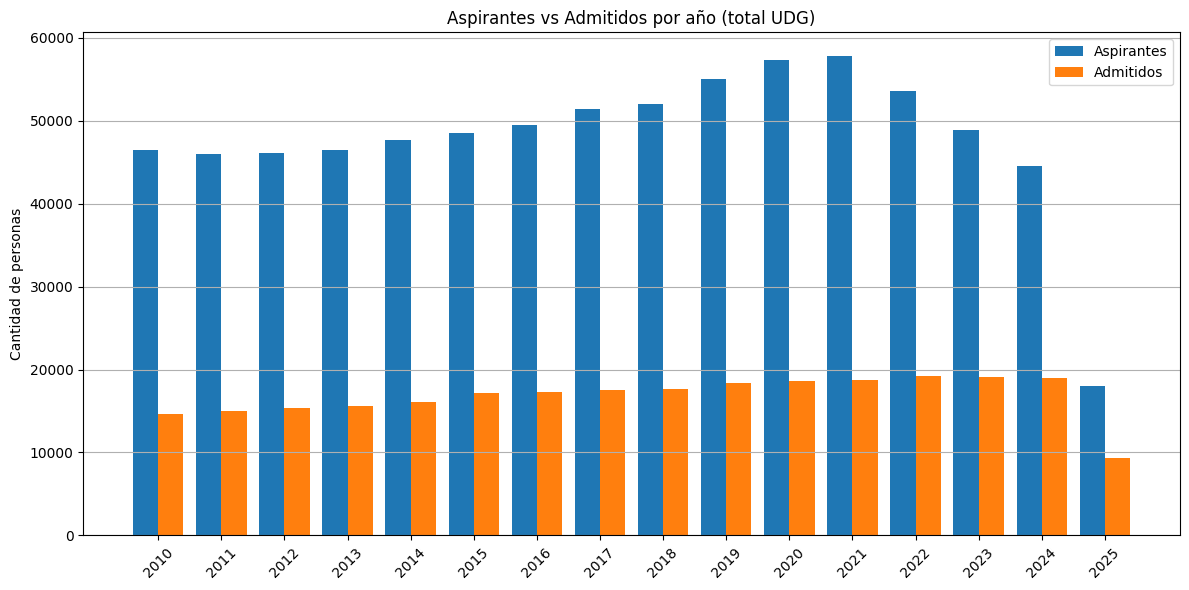

In [ ]:
# Agrupar por año y sumar totales
comparativa_anual = df_carreras.groupby('AÑO')[['ASPIRANTES', 'ADMITIDOS']].sum().reset_index()

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(comparativa_anual['AÑO']))

plt.bar(x, comparativa_anual['ASPIRANTES'], width=bar_width, label='Aspirantes')
plt.bar([i + bar_width for i in x], comparativa_anual['ADMITIDOS'], width=bar_width, label='Admitidos')

plt.xticks([i + bar_width/2 for i in x], comparativa_anual['AÑO'], rotation=45)
plt.ylabel("Cantidad de personas")
plt.title("Aspirantes vs Admitidos por año (total UDG)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



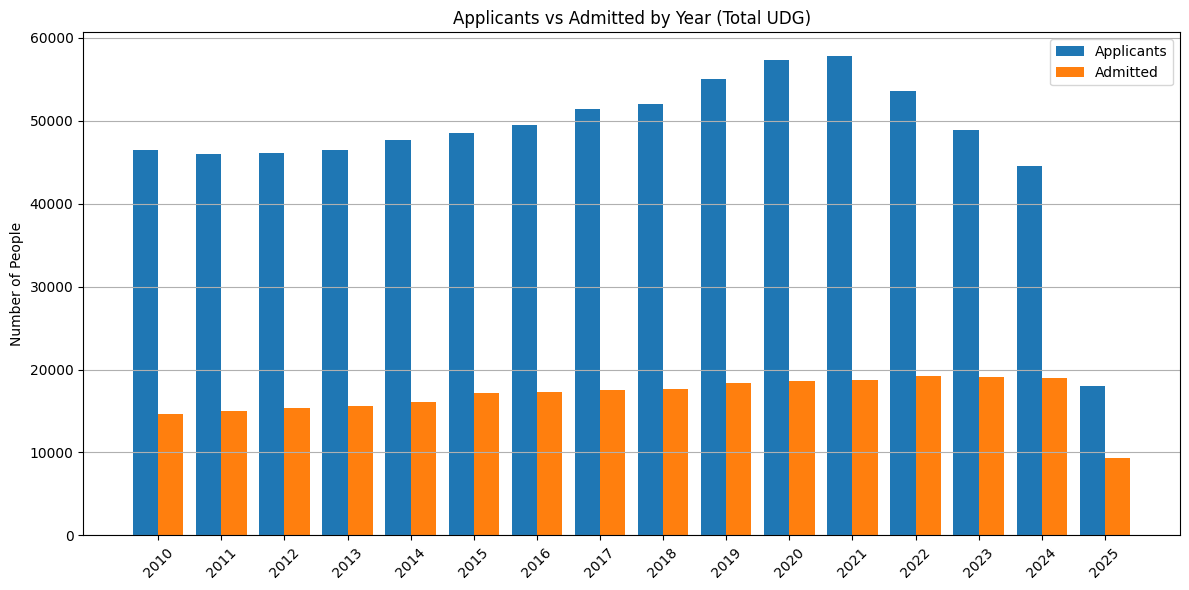

In [ ]:
import matplotlib.pyplot as plt

# Group by year and sum totals
annual_comparison = df_carreras.groupby('AÑO')[['ASPIRANTES', 'ADMITIDOS']].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(annual_comparison['AÑO']))

plt.bar(x, annual_comparison['ASPIRANTES'], width=bar_width, label='Applicants')
plt.bar([i + bar_width for i in x], annual_comparison['ADMITIDOS'], width=bar_width, label='Admitted')

# Axis settings
plt.xticks([i + bar_width / 2 for i in x], annual_comparison['AÑO'], rotation=45)
plt.ylabel("Number of People")
plt.title("Applicants vs Admitted by Year (Total UDG)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save the figure
plt.savefig("applicants_vs_admitted_by_year.png", dpi=300)

# Show the figure
plt.show()


##🟩 SECCIÓN 2. Comparativa entre ciclos A y B

2.1 Evolución de aspirantes por ciclo

🎯 Objetivo:
Comparar la evolución del número de aspirantes en los ciclos A y B a lo largo de los años.

📈 Tipo de gráfico:
Líneas por ciclo (línea A y B)

📋 Variables clave:
* AÑO
* ASPIRANTES
* CICLO

🔎 ¿Qué revela?:
Muestra si hay diferencias sostenidas o patrones entre ambos ciclos.

Esta gráfica permite observar cómo se distribuyen los aspirantes entre ciclos A y B a lo largo del tiempo, lo que puede sugerir una preferencia general por un ciclo.

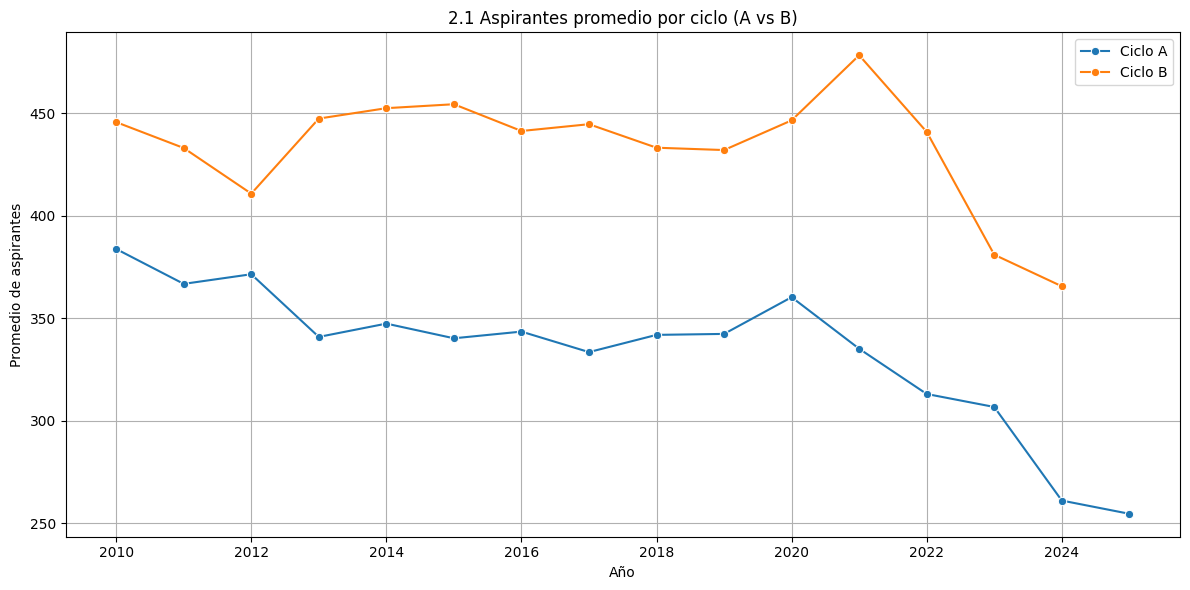

In [ ]:
# Promedio anual por ciclo
media_A = df_ciclo_A.groupby("AÑO")[["ASPIRANTES"]].mean().reset_index()
media_B = df_ciclo_B.groupby("AÑO")[["ASPIRANTES"]].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=media_A, x="AÑO", y="ASPIRANTES", label="Ciclo A", marker="o")
sns.lineplot(data=media_B, x="AÑO", y="ASPIRANTES", label="Ciclo B", marker="o")
plt.title("2.1 Aspirantes promedio por ciclo (A vs B)")
plt.ylabel("Promedio de aspirantes")
plt.xlabel("Año")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2.2 Tasa de demanda y admisión por

🎯 Objetivo:
Comparar qué tan demandados y qué tan accesibles son los ciclos A y B en cada año.

📊 Tipo de gráfico:
Barras agrupadas por ciclo

📋 Variables clave:
* TASA_DE_DEMANDA
* TASA_DE_ADMISION
* CICLO
* AÑO

🔎 ¿Qué revela?:
Muestra si uno de los ciclos tiene más presión de ingreso o una admisión más estricta.

La visualización contrasta las tasas de demanda y de admisión para ciclos A y B, permitiendo inferir cuál ciclo representa una mayor competencia para ingresar.

In [ ]:
# Creamos df_tasas_melted combinando TASA_DEMANDA y TASA_ADMISION
df_tasas_melted = df_carreras.melt(
    id_vars=["AÑO", "CICLO", "CU", "CARRERA"],
    value_vars=["TASA_DEMANDA", "TASA_ADMISION"],
    var_name="TIPO_TASA",
    value_name="VALOR"
)


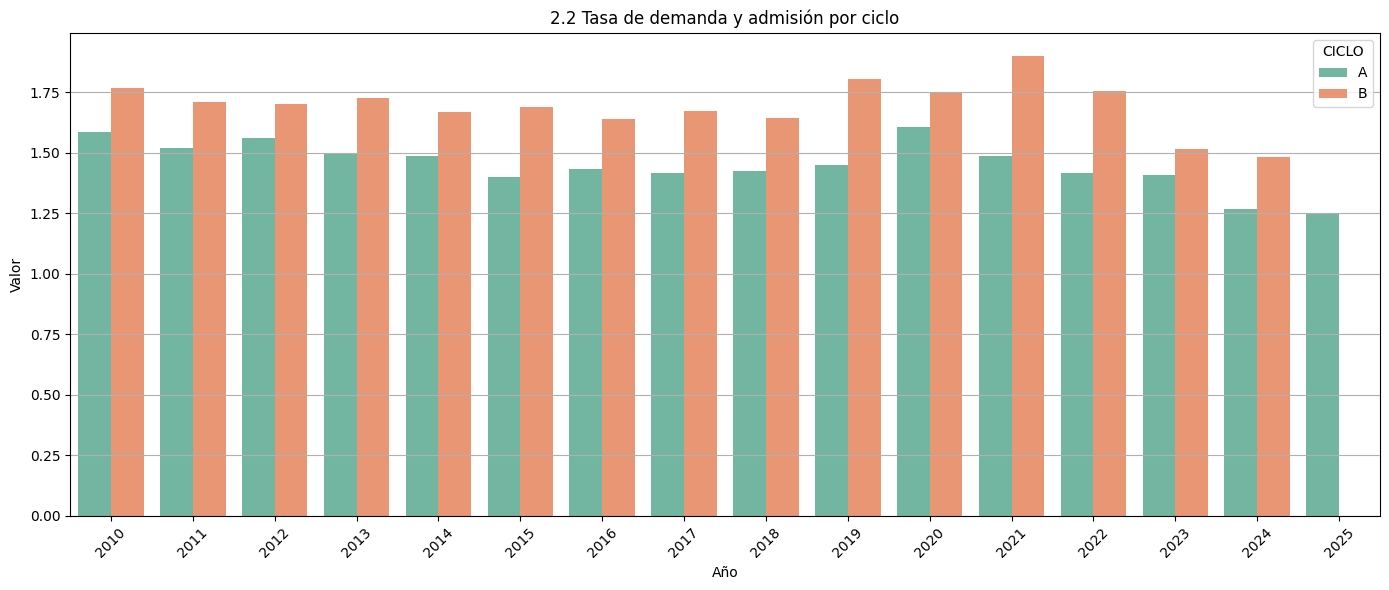

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_tasas_melted,
    x="AÑO",
    y="VALOR",
    hue="CICLO",
    palette="Set2",
    errorbar=None  # ← corrección aquí
)
plt.title("2.2 Tasa de demanda y admisión por ciclo")
plt.ylabel("Valor")
plt.xlabel("Año")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



2.3 Boxplot de puntaje mínimo por ciclo

🎯 Objetivo:
Evaluar si hay diferencias significativas en la distribución del puntaje mínimo por ciclo.

📈 Tipo de gráfico:
Boxplot

📋 Variables clave:
* CICLO
* PUNTAJE_MINIMO

🔎 ¿Qué revela?:
Permite ver si un ciclo tiende a ser más estricto en puntajes o más variable.

El boxplot revela la dispersión de puntaje mínimo por ciclo, ayudando a identificar si existen diferencias marcadas entre A y B.


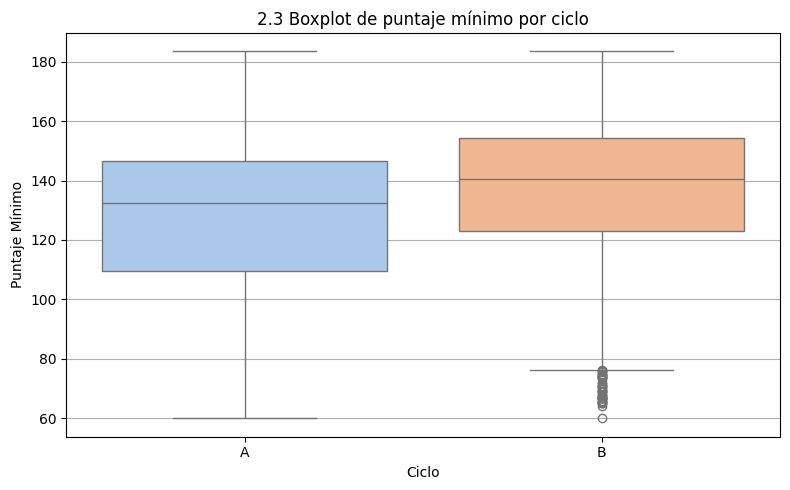

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_carreras,
    x='CICLO',
    y='PUNTAJE_MINIMO',
    hue='CICLO',          # ← corrección
    palette="pastel",
    legend=False          # ← evita leyenda duplicada
)
plt.title("2.3 Boxplot de puntaje mínimo por ciclo")
plt.xlabel("Ciclo")
plt.ylabel("Puntaje Mínimo")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 🟨 SECCIÓN 3. Análisis por CU (Centro Universitario)

3.1 Heatmap de aspirantes por CU y año

🎯 Objetivo:
Visualizar la intensidad de demanda (número de aspirantes) a lo largo del tiempo por cada centro universitario.

📈 Tipo de gráfico:
Heatmap (mapa de calor)

📋 Variables clave:
* CU
* AÑO
* ASPIRANTES

🔎 ¿Qué revela?
Permite detectar periodos con alta o baja demanda por CU y si hay patrones estacionales o cambios fuertes.

Este heatmap muestra cuántos aspirantes ha tenido cada CU a lo largo de los años. Las tonalidades más oscuras indican mayor número de aspirantes.

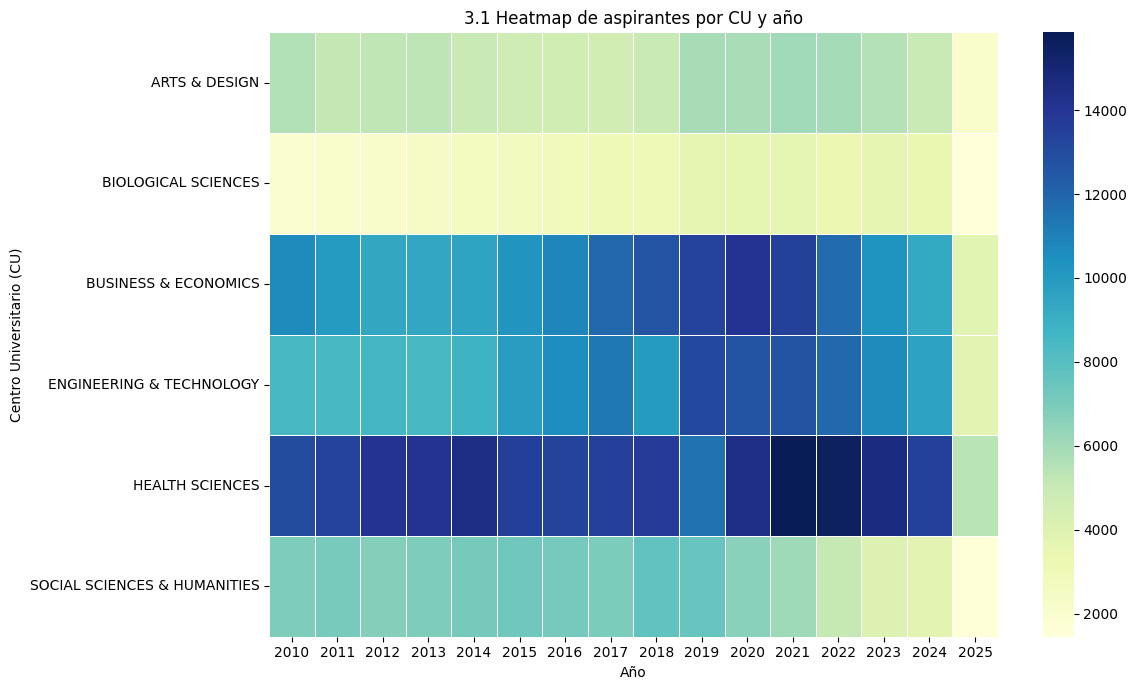

In [ ]:
# Agrupamos por CU y AÑO
cu_aspirantes = df_carreras.groupby(["CU", "AÑO"])["ASPIRANTES"].sum().unstack()

# Plot
plt.figure(figsize=(12, 7))
sns.heatmap(cu_aspirantes, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("3.1 Heatmap de aspirantes por CU y año")
plt.xlabel("Año")
plt.ylabel("Centro Universitario (CU)")
plt.tight_layout()
plt.show()

3.2 Barras apiladas por admitidos por CU y carrera

🎯 Objetivo:
Visualizar qué tantas carreras contribuyen a los admitidos totales por cada CU.

📊 Tipo de gráfico:
Barras apiladas

📋 Variables clave:
* CU
* CARRERA
* ADMITIDOS

🔎 ¿Qué revela?
Permite ver si pocas carreras concentran la mayoría de los admitidos o si hay una distribución equilibrada en cada CU.

Las barras muestran cuántos admitidos aporta cada carrera dentro de su respectivo CU. Esto permite identificar carreras dominantes o centros con alta diversidad académica.

<ipython-input-76-2329049469>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


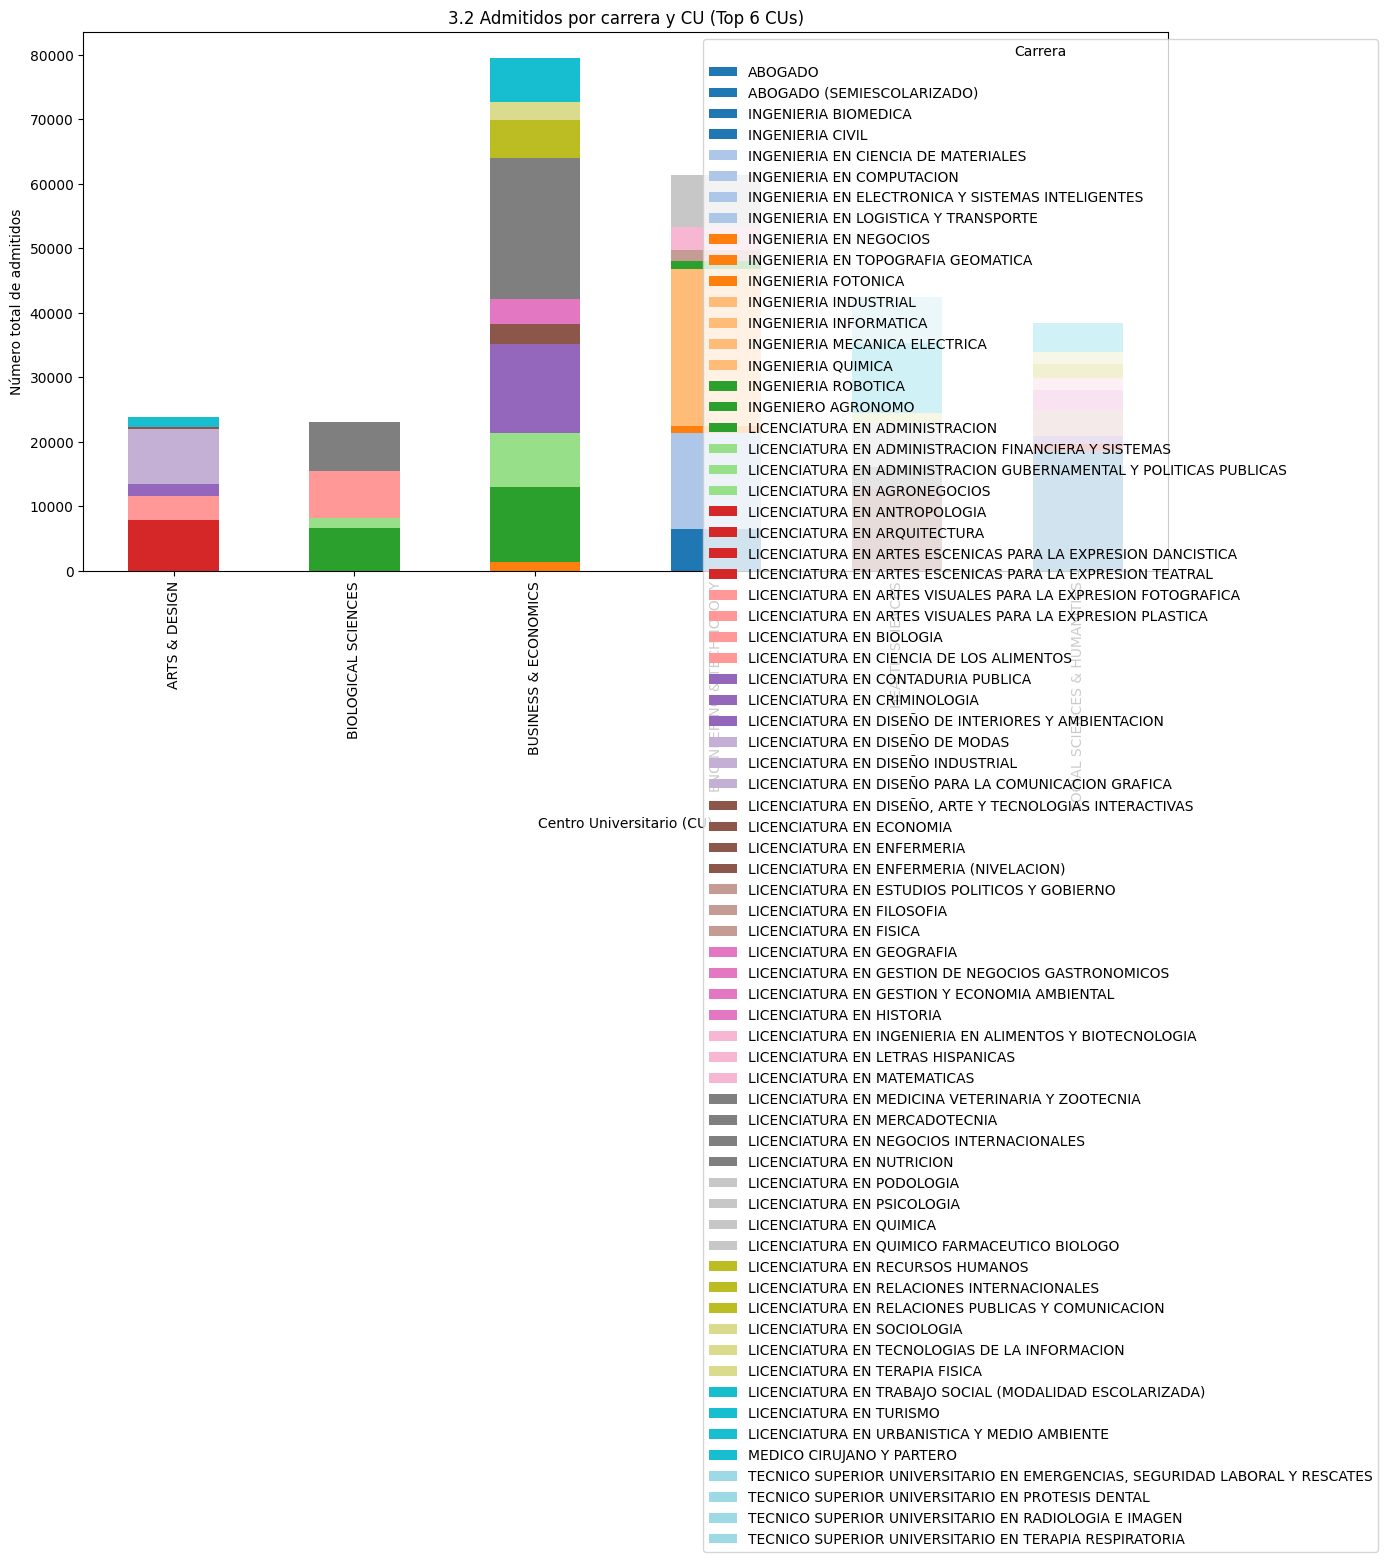

In [ ]:
# Agrupamos admitidos por CU y carrera
admitidos_cu = df_carreras.groupby(["CU", "CARRERA"])["ADMITIDOS"].sum().reset_index()

# Tomamos los 6 CUs con más admitidos para visualización
top_cus = admitidos_cu.groupby("CU")["ADMITIDOS"].sum().nlargest(6).index
admitidos_top = admitidos_cu[admitidos_cu["CU"].isin(top_cus)]

# Pivot para barras apiladas
pivot = admitidos_top.pivot_table(index="CU", columns="CARRERA", values="ADMITIDOS", fill_value=0)

# Gráfico
pivot.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title("3.2 Admitidos por carrera y CU (Top 6 CUs)")
plt.ylabel("Número total de admitidos")
plt.xlabel("Centro Universitario (CU)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), title="Carrera")
plt.tight_layout()
plt.show()


## 🟧 SECCIÓN 4. Análisis por carrera

4.1 Ranking de carreras con mayor demanda

🎯 Objetivo:
Visualizar las carreras más populares en función del número total de aspirantes acumulado.

📊 Tipo de gráfico:
Barras horizontales (Top 15)

📋 Variables clave:
* CARRERA
* ASPIRANTES

🔎 ¿Qué revela?
Un ranking de popularidad de carreras dentro de la UDG.


Estas son las carreras más demandadas a lo largo del tiempo, considerando el número total de aspirantes que han intentado ingresar a cada una.


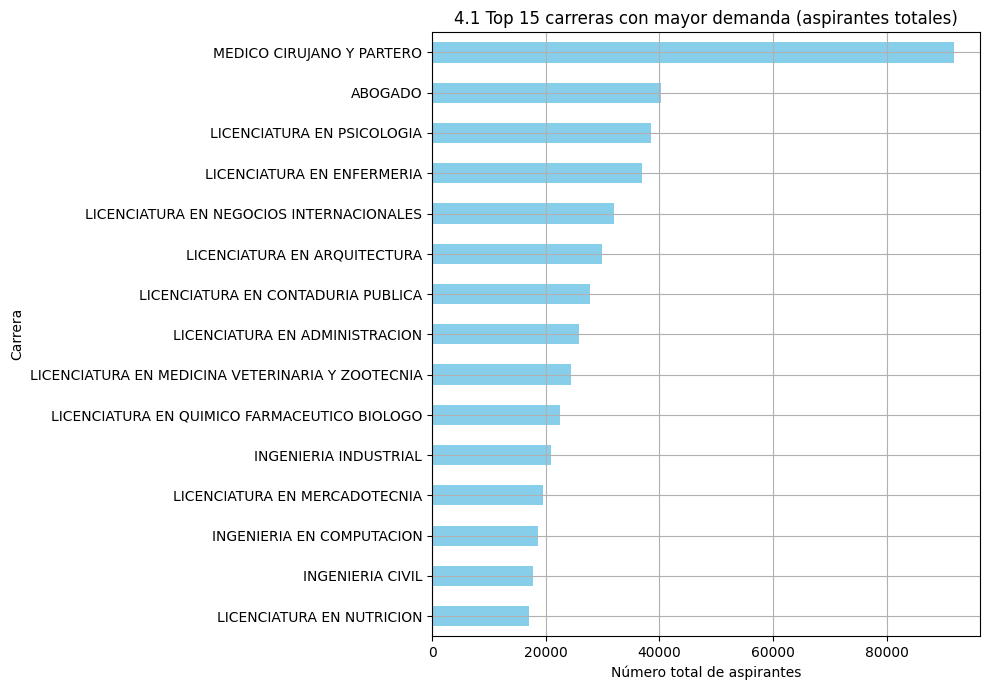

In [ ]:
# Agrupar aspirantes totales por carrera
ranking_carreras = df_carreras.groupby("CARRERA")["ASPIRANTES"].sum().nlargest(15).sort_values()

# Gráfico
plt.figure(figsize=(10, 7))
ranking_carreras.plot(kind='barh', color='skyblue')
plt.title("4.1 Top 15 carreras con mayor demanda (aspirantes totales)")
plt.xlabel("Número total de aspirantes")
plt.ylabel("Carrera")
plt.grid(True)
plt.tight_layout()
plt.show()


4.2 Evolución de puntaje mínimo por carrera clave

🎯 Objetivo:
Visualizar cómo ha cambiado el puntaje mínimo (PM) de ingreso en carreras representativas.

📈 Tipo de gráfico:
Línea múltiple

📋 Variables clave:
* AÑO
* PUNTAJE_MINIMO
* CARRERA

🔎 ¿Qué revela?
Carreras que se han vuelto más o menos competitivas con el tiempo.

El gráfico muestra la evolución del puntaje mínimo requerido para ingresar en carreras clave, lo que refleja la competitividad académica de cada una.

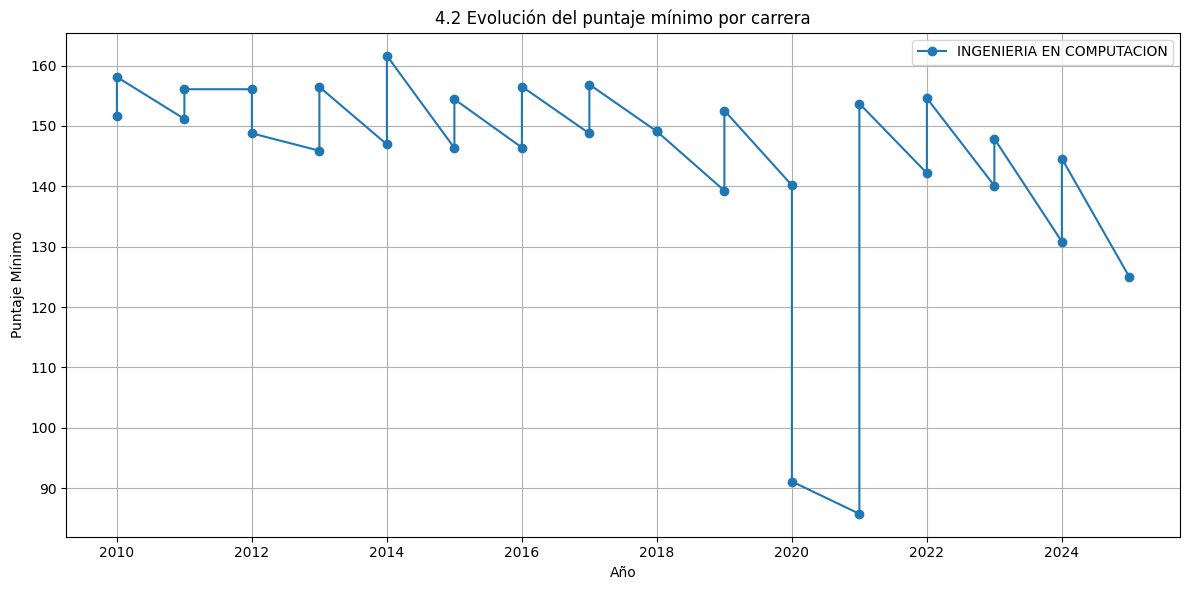

In [ ]:
# Selecciona carreras representativas
carreras_clave = [
    "INGENIERIA EN COMPUTACION",
]

plt.figure(figsize=(12, 6))
for carrera in carreras_clave:
    sub = df_carreras[df_carreras["CARRERA"] == carrera]
    plt.plot(sub["AÑO"], sub["PUNTAJE_MINIMO"], marker="o", label=carrera)

plt.title("4.2 Evolución del puntaje mínimo por carrera")
plt.xlabel("Año")
plt.ylabel("Puntaje Mínimo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


4.3 Bubble Chart de aspirantes vs admitidos vs puntaje mínimo

🎯 Objetivo:
Explorar la relación entre aspirantes, admitidos y puntaje mínimo por carrera.

📊 Tipo de gráfico:
Gráfico de burbujas (scatter con tamaño y color)

📋 Variables clave:
* ASPIRANTES
* ADMITIDOS
* PUNTAJE_MINIMO
* CARRERA

🔎 ¿Qué revela?
Carreras con alta demanda pero baja admisión, o aquellas con alta admisión y bajo puntaje, entre otros patrones.


Las burbujas representan carreras; el tamaño indica cuántos fueron admitidos, la posición cuántos aspirantes hubo y el color el nivel de puntaje mínimo requerido.

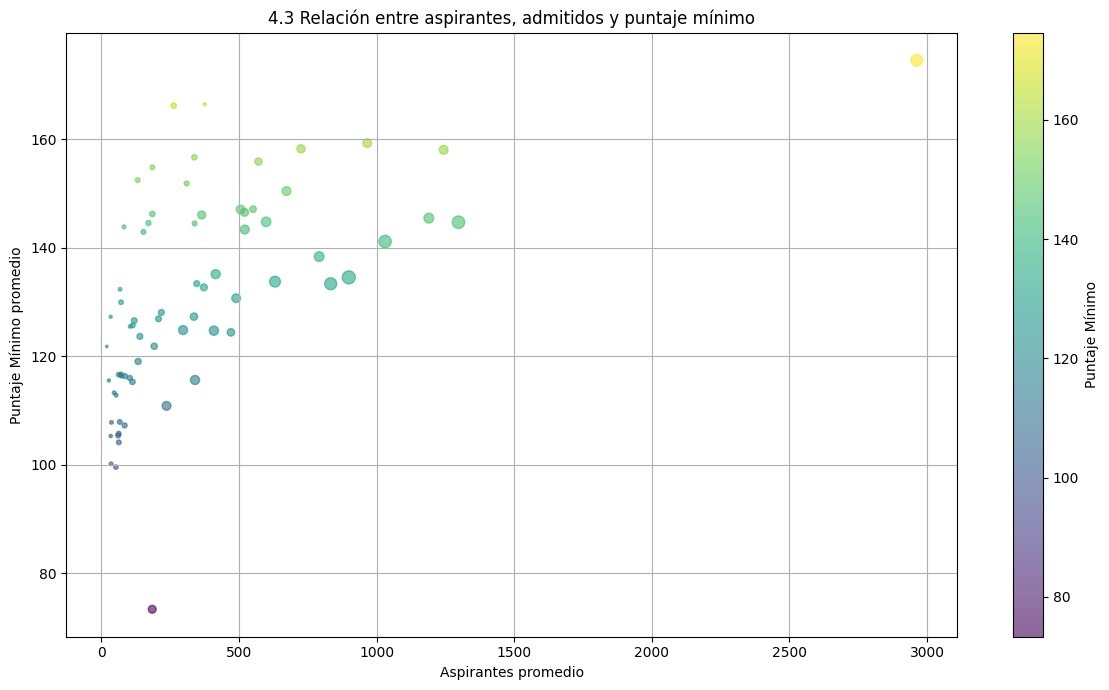

In [ ]:
# Agregar promedios por carrera
df_bubble = df_carreras.groupby("CARRERA")[["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]].mean().reset_index()

plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    x=df_bubble["ASPIRANTES"],
    y=df_bubble["PUNTAJE_MINIMO"],
    s=df_bubble["ADMITIDOS"] * 0.2,  # escala tamaño
    alpha=0.6,
    c=df_bubble["PUNTAJE_MINIMO"],
    cmap="viridis"
)
plt.xlabel("Aspirantes promedio")
plt.ylabel("Puntaje Mínimo promedio")
plt.title("4.3 Relación entre aspirantes, admitidos y puntaje mínimo")
plt.grid(True)
plt.colorbar(scatter, label="Puntaje Mínimo")
plt.tight_layout()
plt.show()


In [ ]:
# Calcular tasa de demanda
df_bubble["TASA_DEMANDA"] = df_bubble["ASPIRANTES"] / df_bubble["ADMITIDOS"]

# Seleccionar Top 5 con mayor tasa
top_5_carreras = df_bubble.sort_values("TASA_DEMANDA", ascending=False).head(5)

# Mostrar tabla
top_5_carreras


TIPO                                            CARRERA   ASPIRANTES  \
35    LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGIAS INT...   375.846154   
66                            MEDICO CIRUJANO Y PARTERO  2962.516129   
54                           LICENCIATURA EN PSICOLOGIA  1243.741935   
62                       LICENCIATURA EN TERAPIA FISICA   338.925926   
52                            LICENCIATURA EN NUTRICION   551.483871   

TIPO   ADMITIDOS  PUNTAJE_MINIMO  TASA_DEMANDA  
35     26.384615      166.449492     14.244898  
66    350.677419      174.564352      8.447981  
54    204.580645      158.054523      6.079470  
62     59.111111      144.470726      5.733709  
52    110.612903      147.105803      4.985710

##🟥 SECCIÓN 5. Impacto de la pandemia

5.1 Gráfica antes/durante/después de COVID (por carrera)

📈 Tipo de gráfico:
Líneas múltiples con marcadores de eventos (líneas verticales para pandemia)

📋 Variables:
* PERIODO
* ASPIRANTES
* TASA_DEMANDA
* PUNTAJE_MINIMO
* CARRERA

🔎 ¿Qué revela?
Cambios bruscos en la demanda y dificultad de ingreso durante los años afectados por COVID (2020A a 2022B), y su comparación con los periodos anteriores y posteriores.


Se muestran las tendencias históricas de cada carrera destacando los efectos de la pandemia en las métricas clave. Las líneas rojas marcan el inicio (2020A) y final estimado (2023A) de la pandemia.

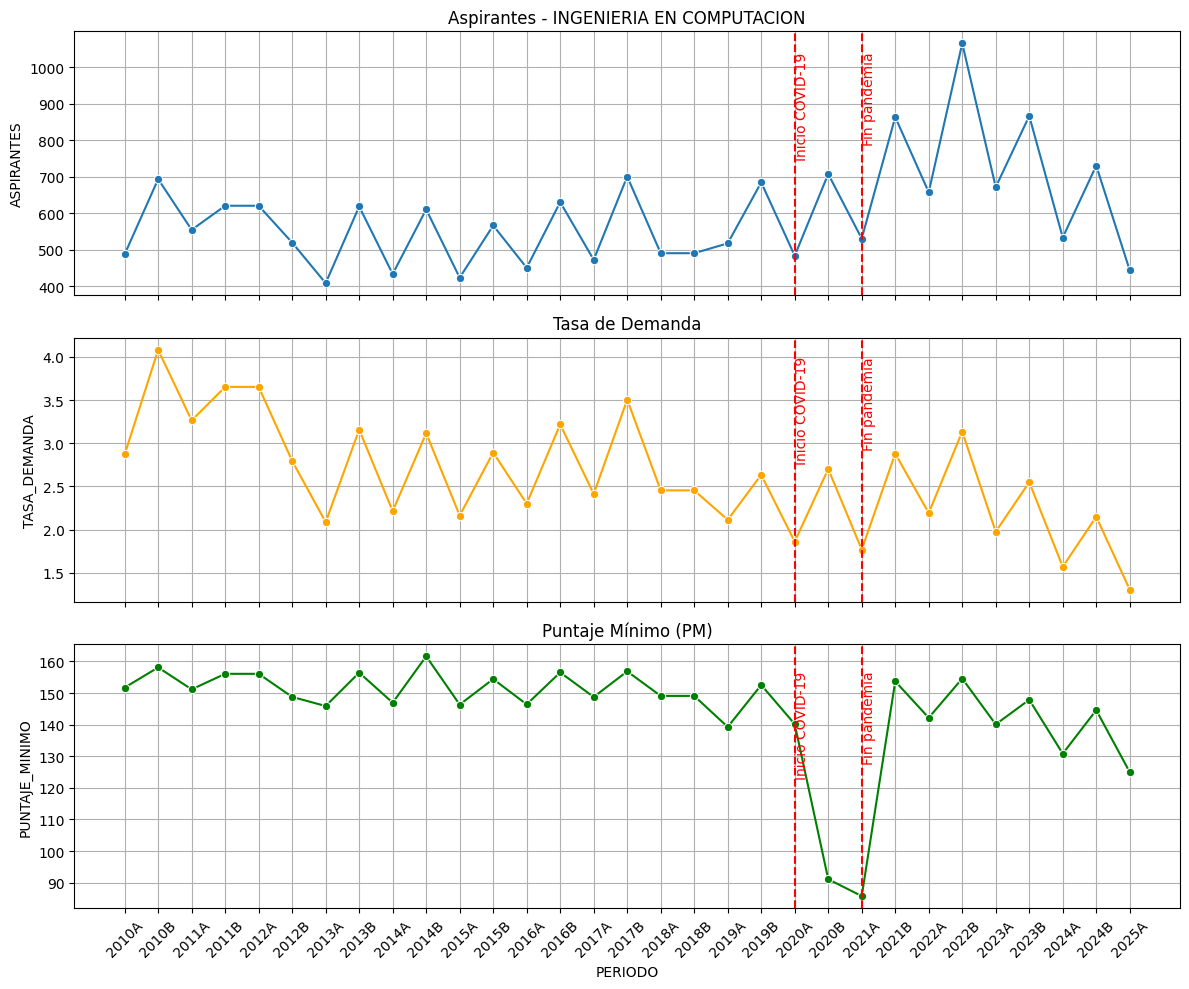

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Eventos importantes
eventos = {
    '2020A': 'Inicio COVID-19',
    '2021A': 'Fin pandemia'
}

def graficar_carrera_con_eventos(carrera):
    datos = df_carreras[df_carreras['CARRERA'] == carrera]

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Aspirantes
    sns.lineplot(data=datos, x='PERIODO', y='ASPIRANTES', marker='o', ax=axs[0])
    axs[0].set_title(f'Aspirantes - {carrera}')
    axs[0].grid()

    # Tasa de Demanda
    sns.lineplot(data=datos, x='PERIODO', y='TASA_DEMANDA', marker='o', color='orange', ax=axs[1])
    axs[1].set_title('Tasa de Demanda')
    axs[1].grid()

    # PM
    sns.lineplot(data=datos, x='PERIODO', y='PUNTAJE_MINIMO', marker='o', color='green', ax=axs[2])
    axs[2].set_title('Puntaje Mínimo (PM)')
    axs[2].grid()

    # Líneas de eventos
    for ax in axs:
        for periodo, etiqueta in eventos.items():
            if periodo in datos['PERIODO'].values:
                ax.axvline(x=periodo, color='red', linestyle='--')
                ax.text(periodo, ax.get_ylim()[1]*0.95, etiqueta, rotation=90, color='red', verticalalignment='top')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
graficar_carrera_con_eventos('INGENIERIA EN COMPUTACION')


5.2 Comparación antes, durante y después de la pandemia

🎯 Objetivo:
Comparar el número de aspirantes y el puntaje mínimo antes (pre-2020), durante (2020–2021) y después de la pandemia.

📊 Tipo de gráfico:
Barras agrupadas o FacetGrid

📋 Variables clave:
* AÑO
* ASPIRANTES
* PUNTAJE_MINIMO
* PERIODO_PANDEMIA (etiquetado como “PRE”, “DURANTE”, “POST”)

🔎 ¿Qué revela?
Si hubo una caída, estabilización o recuperación en la demanda o los puntajes después del impacto del COVID-19.


El gráfico compara métricas clave de ingreso antes, durante y después de la pandemia de COVID-19, para observar su impacto en la demanda y dificultad de acceso a las carreras.

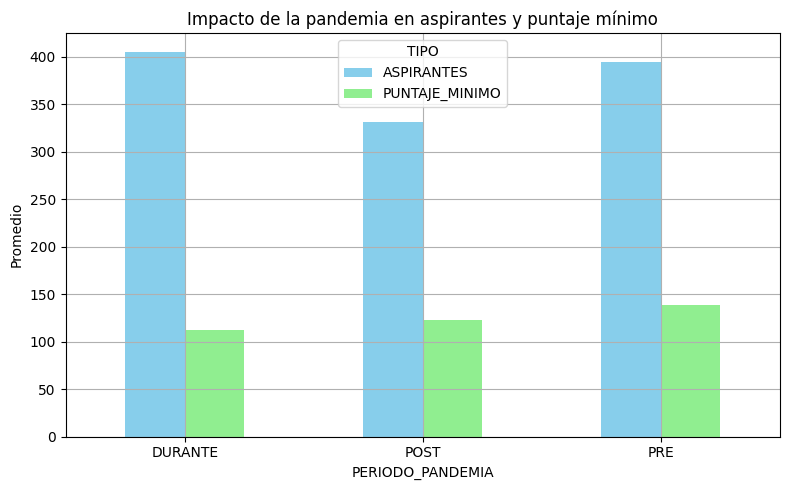

In [ ]:
# Clasificar periodo según pandemia
def clasificar_periodo(año):
    if año <= 2019:
        return "PRE"
    elif año in [2020, 2021]:
        return "DURANTE"
    else:
        return "POST"

df_carreras["PERIODO_PANDEMIA"] = df_carreras["AÑO"].apply(clasificar_periodo)

# Agrupamos por periodo
df_pandemia = df_carreras.groupby("PERIODO_PANDEMIA")[["ASPIRANTES", "PUNTAJE_MINIMO"]].mean().reset_index()

# Gráfica
fig, ax1 = plt.subplots(figsize=(8, 5))
df_pandemia.plot(kind='bar', x="PERIODO_PANDEMIA", ax=ax1, color=["skyblue", "lightgreen"])
plt.title("Impacto de la pandemia en aspirantes y puntaje mínimo")
plt.ylabel("Promedio")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


5.3 Regresión lineal por periodo pandémico

🎯 Objetivo general:
Evaluar con modelos de regresión lineal cómo se han comportado las variables clave (aspirantes, admitidos y puntaje mínimo) antes, durante y después de la pandemia, diferenciando por carrera y por centro universitario.

Las líneas de regresión ayudan a identificar tendencias claras de crecimiento o decrecimiento, incluso cuando los datos por sí solos no lo hacen evidente.



In [ ]:
# 🧠 Clasificamos cada semestre como 'Antes', 'Durante' o 'Después' de la pandemia
def clasificar_periodo(p):
    año = int(p[:4])
    if año < 2020:
        return "Antes"
    elif 2020 <= año <= 2022:
        return "Durante"
    else:
        return "Después"

# Aplicamos clasificación al DataFrame
df_carreras["PERIODO_PANDEMIA"] = df_carreras["PERIODO"].apply(clasificar_periodo)


5.3a Regresión por carrera (comparativa antes/durante/después)

📈 Tipo de gráfico:
* lmplot() de Seaborn
* Una subgráfica por carrera
* Líneas de regresión separadas para los tres periodos pandémicos

📋 Variables:
* AÑO
* ASPIRANTES
* ADMITIDOS
* PUNTAJE_MINIMO
* PERIODO_PANDEMIA
* CARRERA (filtrado por un conjunto clave)

🔎 ¿Qué revela?
* Pendiente positiva: crecimiento sostenido en la variable (ej. más aspirantes o mayor puntaje).
* Pendiente negativa: caída progresiva.
* Permite comparar si ciertas carreras se han vuelto más atractivas o han perdido interés, especialmente después del COVID.


Este gráfico muestra cómo evolucionaron los valores de aspirantes, admitidos y puntaje mínimo en carreras clave antes, durante y después de la pandemia. Las líneas de regresión ayudan a visualizar tendencias de recuperación, declive o estabilidad en el comportamiento de cada carrera.

In [ ]:
from sklearn.linear_model import LinearRegression

carreras_clave = ["INGENIERIA BIOMEDICA"]
periodos = ["PRE", "DURANTE", "POST"]
variables = ["ASPIRANTES", "PUNTAJE_MINIMO", "ADMITIDOS"]

for carrera in carreras_clave:
    print(f"\n=== CARRERA: {carrera} ===")
    df_filtro = df_carreras[df_carreras["CARRERA"] == carrera]

    for variable in variables:
        print(f"\n--- Variable: {variable} ---")

        for periodo in periodos:
            sub = df_filtro[df_filtro["PERIODO_PANDEMIA"] == periodo].dropna(subset=[variable])
            if len(sub) >= 2:
                X = sub[["AÑO"]].values
                y = sub[variable].values
                model = LinearRegression().fit(X, y)
                r2 = model.score(X, y)
                pendiente = model.coef_[0]
                print(f"{periodo}: R² = {r2:.3f}, pendiente = {pendiente:.2f}")
            else:
                print(f"{periodo}: datos insuficientes")



=== CARRERA: INGENIERIA BIOMEDICA ===

--- Variable: ASPIRANTES ---
PRE: datos insuficientes
DURANTE: datos insuficientes
POST: datos insuficientes

--- Variable: PUNTAJE_MINIMO ---
PRE: datos insuficientes
DURANTE: datos insuficientes
POST: datos insuficientes

--- Variable: ADMITIDOS ---
PRE: datos insuficientes
DURANTE: datos insuficientes
POST: datos insuficientes


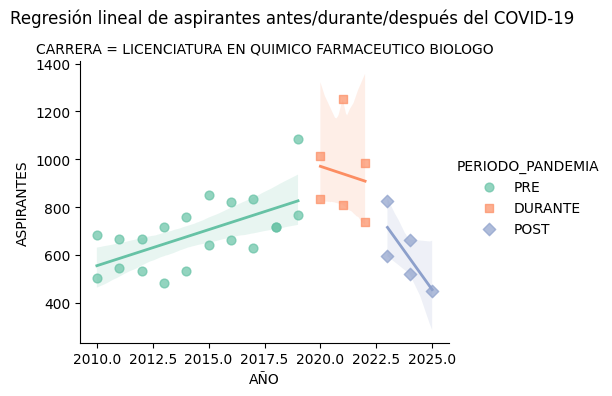

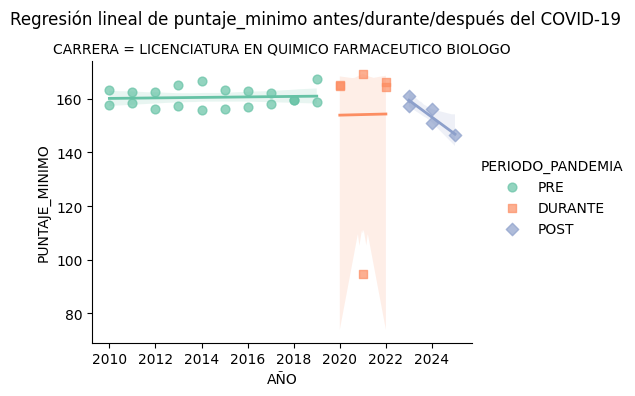

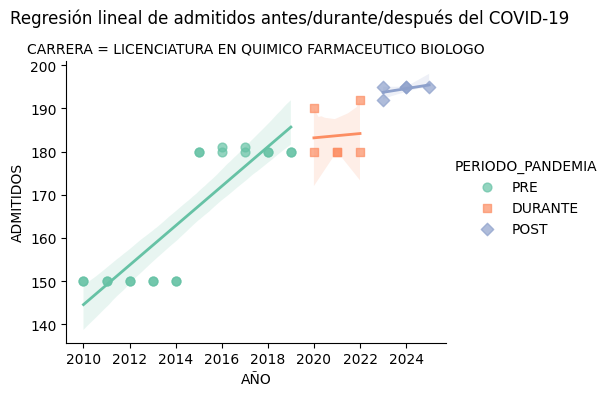

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✍️ Puedes modificar este diccionario para elegir tus carreras clave
carreras_clave = [
    "LICENCIATURA EN QUIMICO FARMACEUTICO BIOLOGO"
]

# 🔍 Visualizamos regresiones por cada variable en las carreras seleccionadas
for variable in ["ASPIRANTES", "PUNTAJE_MINIMO", "ADMITIDOS"]:
    g = sns.lmplot(
        data=df_carreras[df_carreras["CARRERA"].isin(carreras_clave)],
        x="AÑO", y=variable,
        col="CARRERA",
        hue="PERIODO_PANDEMIA",
        height=4, aspect=1.2,
        markers=["o", "s", "D"],
        palette="Set2",
        scatter_kws={'s': 40, 'alpha': 0.7},
        line_kws={'linewidth': 2}
    )
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Regresión lineal de {variable.lower()} antes/durante/después del COVID-19")

    # Muestra la figura (esto va DESPUÉS de guardarla)
    plt.show()



In [ ]:
variable_labels = {
    "ASPIRANTES": "Applicants",
    "PUNTAJE_MINIMO": "Minimum Score",
    "ADMITIDOS": "Admitted"
}




Figure 'regression_applicants.png' saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

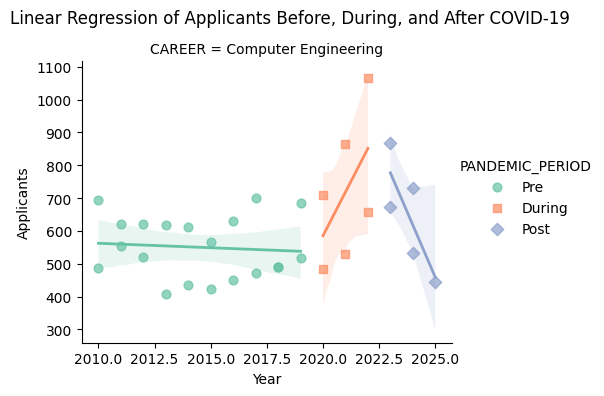

Figure 'regression_minimum_score.png' saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

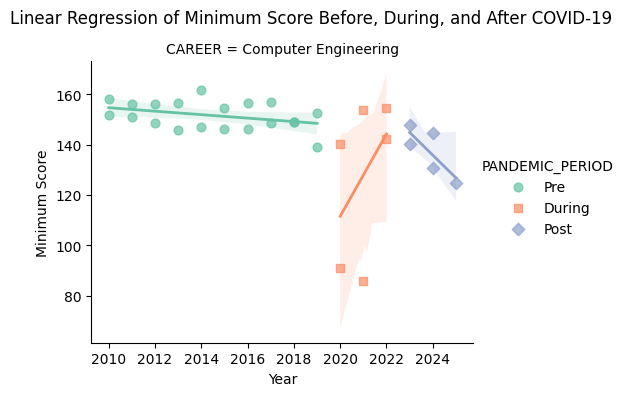

Figure 'regression_admitted.png' saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

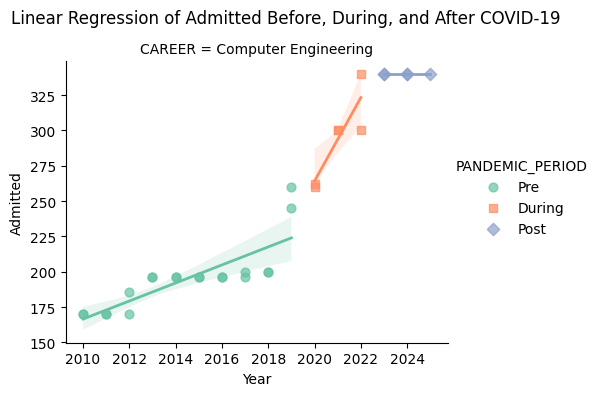

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files  # Omitir esta línea si no usas Colab

# Traducir periodo pandémico
df_carreras["PANDEMIC_PERIOD"] = df_carreras["PERIODO_PANDEMIA"].map({
    "PRE": "Pre",
    "DURANTE": "During",
    "POST": "Post"
})

# Etiquetas en inglés para variables
variable_labels = {
    "ASPIRANTES": "Applicants",
    "PUNTAJE_MINIMO": "Minimum Score",
    "ADMITIDOS": "Admitted"
}

# Lista de carreras clave
key_careers = [
    "INGENIERIA EN COMPUTACION"
]

# Si deseas traducir nombres de carrera también (opcional)
career_translation = {
    "INGENIERIA EN COMPUTACION": "Computer Engineering"
}

# Aplicar traducción de carrera si lo deseas
df_carreras["CAREER"] = df_carreras["CARRERA"].replace(career_translation)

# Visualización y guardado
for variable in variable_labels:
    label = variable_labels[variable]

    g = sns.lmplot(
        data=df_carreras[df_carreras["CARRERA"].isin(key_careers)],
        x="AÑO", y=variable,
        col="CAREER",
        hue="PANDEMIC_PERIOD",
        height=4, aspect=1.2,
        markers=["o", "s", "D"],
        palette="Set2",
        scatter_kws={'s': 40, 'alpha': 0.7},
        line_kws={'linewidth': 2}
    )

    # Títulos
    g.set_ylabels(label)
    g.set_xlabels("Year")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Linear Regression of {label} Before, During, and After COVID-19")

    # Guardar archivo
    file_name = f"regression_{label.lower().replace(' ', '_')}.png"
    g.savefig(file_name, dpi=300, bbox_inches="tight")
    print(f"Figure '{file_name}' saved successfully.")

    # Descargar archivo (solo si estás en Colab)
    try:
        files.download(file_name)
        print(f"Downloading '{file_name}'...")
    except:
        pass

    plt.show()



5.3b Regresión por centro universitario (promedio anual)

📈 Tipo de gráfico:
* lmplot() por CU (una subgráfica por centro)
* Cada punto es un promedio anual de todos los programas del CU
* Colores según el periodo pandémico

📋 Variables:
* CU
* AÑO
* ASPIRANTES (promedio)
* ADMITIDOS (promedio)
* PUNTAJE_MINIMO (promedio)
* PERIODO_PANDEMIA

🔎 ¿Qué revela?
* Identifica CUs que perdieron o ganaron demanda tras la pandemia.
* Visualiza si la competitividad cambió (por puntaje mínimo promedio).
* Puede destacar desigualdad en la recuperación entre centros regionales y metropolitanos.


Esta visualización compara las tendencias de ingreso y competitividad por centro universitario de la UDG antes, durante y después del COVID-19. Las líneas de regresión permiten analizar si el interés por cada centro ha ido en aumento o ha disminuido, así como el impacto en la dificultad de ingreso.

In [ ]:
from sklearn.linear_model import LinearRegression

# Agrupamos por CU, periodo y año (esto ya lo hiciste)
df_cu_agg = df_carreras.groupby(['CU', 'PERIODO_PANDEMIA', 'AÑO'])[
    ['ASPIRANTES', 'ADMITIDOS', 'PUNTAJE_MINIMO']
].mean().reset_index()

# Variables y periodos a analizar
variables = ['ASPIRANTES', 'ADMITIDOS', 'PUNTAJE_MINIMO']
periodos = ['PRE', 'DURANTE', 'POST']
centros = df_cu_agg['CU'].unique()

# Cálculo de regresiones
for var in variables:
    print(f"\n=== VARIABLE: {var} ===")
    for cu in centros:
        for periodo in periodos:
            sub = df_cu_agg[
                (df_cu_agg["CU"] == cu) &
                (df_cu_agg["PERIODO_PANDEMIA"] == periodo)
            ].dropna(subset=[var])
            if len(sub) >= 2:
                X = sub[["AÑO"]].values
                y = sub[var].values
                model = LinearRegression().fit(X, y)
                r2 = model.score(X, y)
                pendiente = model.coef_[0]
                print(f"{cu} | {periodo}: R² = {r2:.3f}, pendiente = {pendiente:.2f}")
            else:
                print(f"{cu} | {periodo}: datos insuficientes")



=== VARIABLE: ASPIRANTES ===
ARTS & DESIGN | PRE: datos insuficientes
ARTS & DESIGN | DURANTE: datos insuficientes
ARTS & DESIGN | POST: datos insuficientes
BIOLOGICAL SCIENCES | PRE: datos insuficientes
BIOLOGICAL SCIENCES | DURANTE: datos insuficientes
BIOLOGICAL SCIENCES | POST: datos insuficientes
BUSINESS & ECONOMICS | PRE: datos insuficientes
BUSINESS & ECONOMICS | DURANTE: datos insuficientes
BUSINESS & ECONOMICS | POST: datos insuficientes
ENGINEERING & TECHNOLOGY | PRE: datos insuficientes
ENGINEERING & TECHNOLOGY | DURANTE: datos insuficientes
ENGINEERING & TECHNOLOGY | POST: datos insuficientes
HEALTH SCIENCES | PRE: datos insuficientes
HEALTH SCIENCES | DURANTE: datos insuficientes
HEALTH SCIENCES | POST: datos insuficientes
SOCIAL SCIENCES & HUMANITIES | PRE: datos insuficientes
SOCIAL SCIENCES & HUMANITIES | DURANTE: datos insuficientes
SOCIAL SCIENCES & HUMANITIES | POST: datos insuficientes

=== VARIABLE: ADMITIDOS ===
ARTS & DESIGN | PRE: datos insuficientes
ARTS & DE

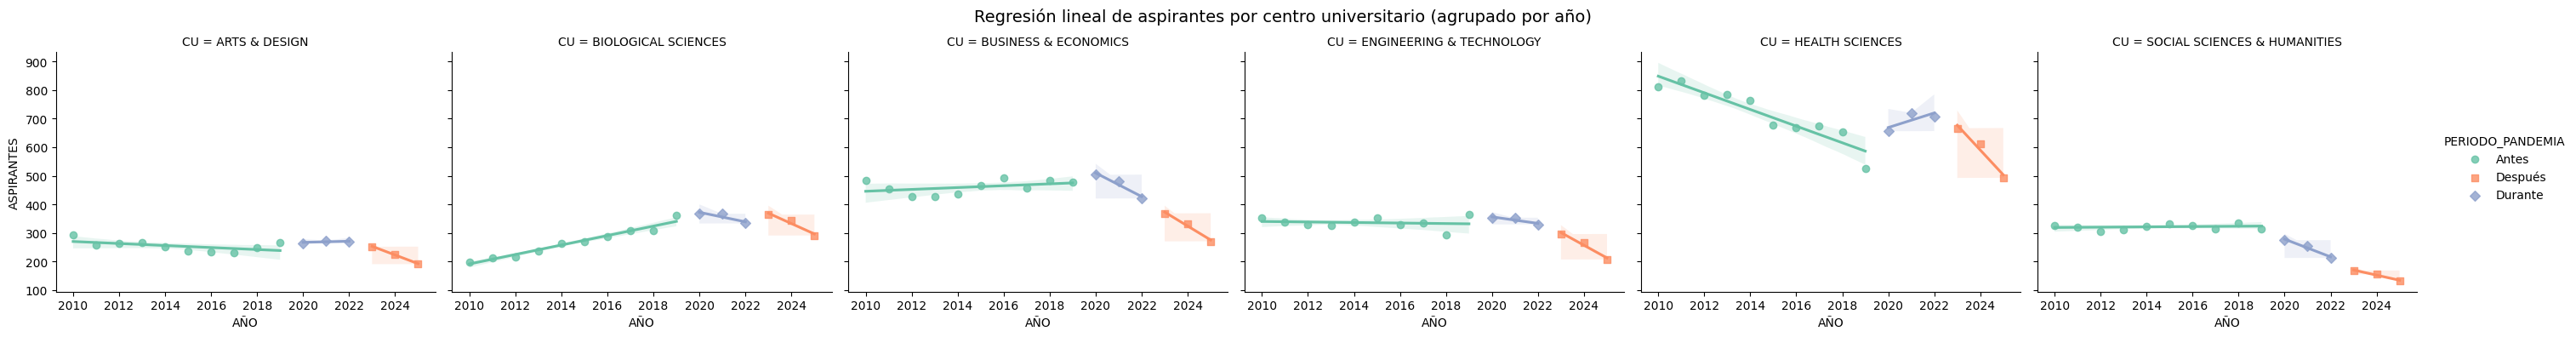

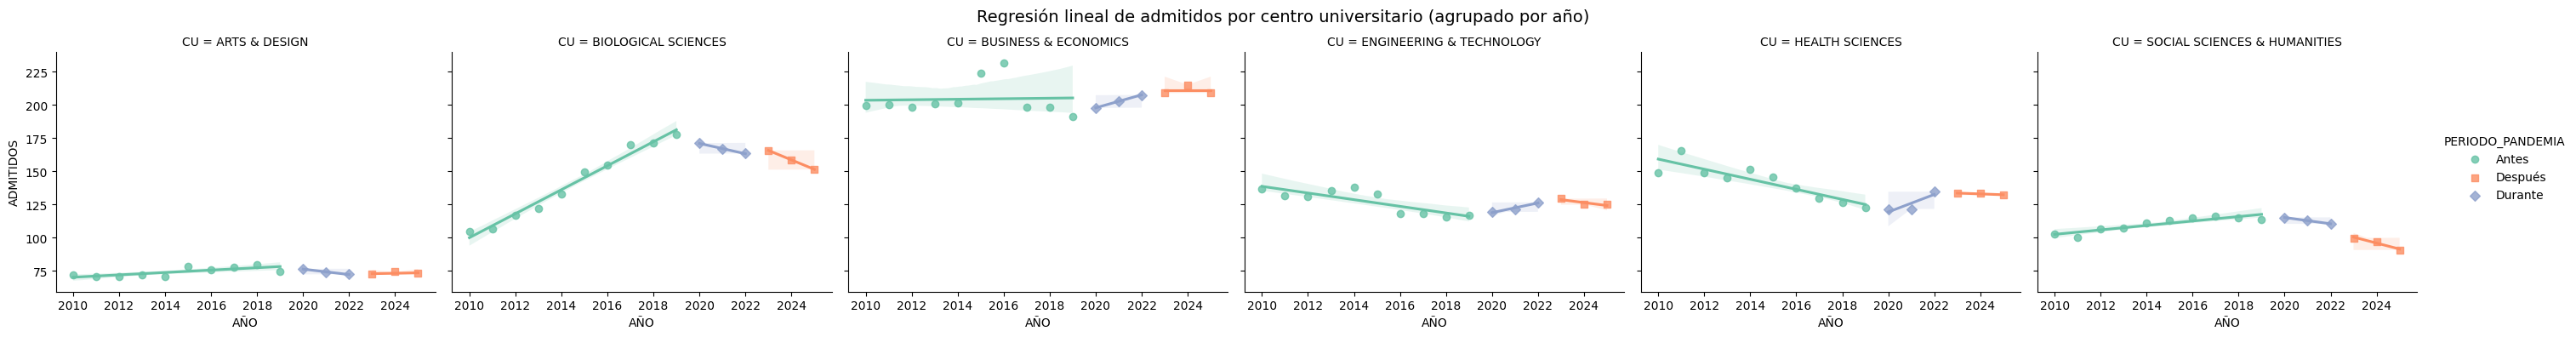

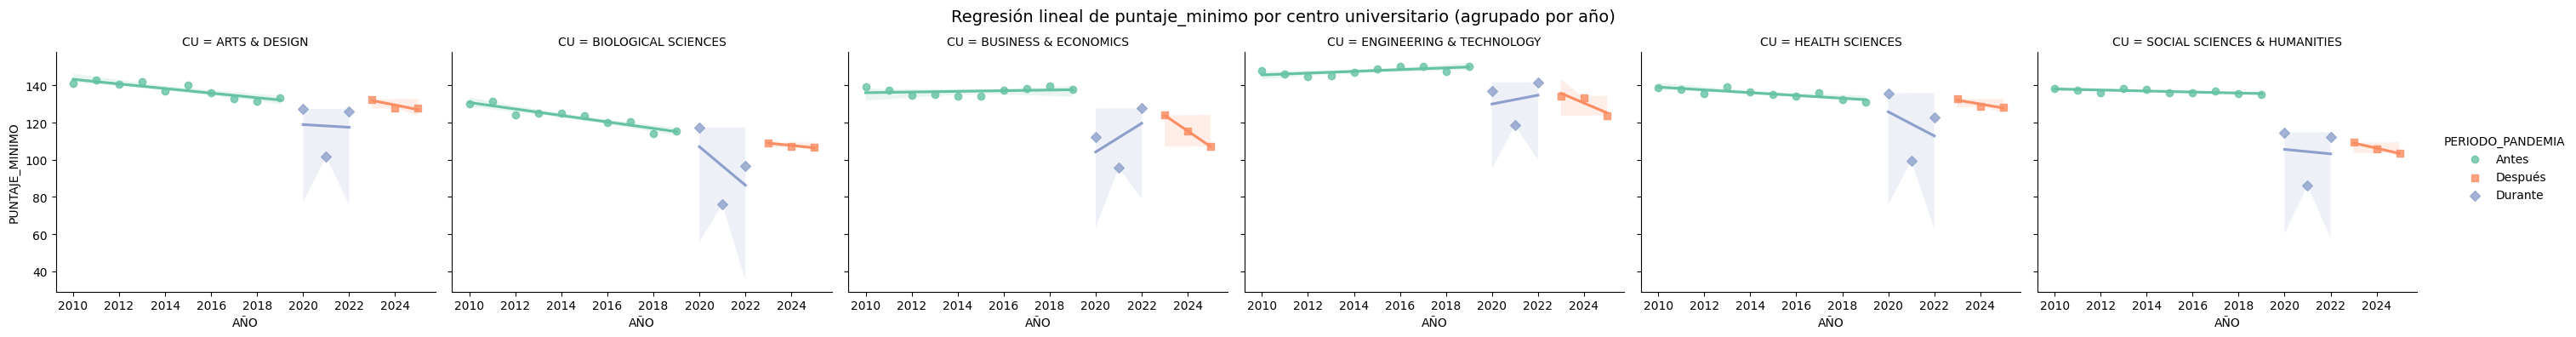

In [ ]:
# Agrupar por CU, PERIODO_PANDEMIA y AÑO
df_cu_agg = df_carreras.groupby(['CU', 'PERIODO_PANDEMIA', 'AÑO'])[
    ['ASPIRANTES', 'ADMITIDOS', 'PUNTAJE_MINIMO']
].mean().reset_index()

# Crear gráficos de regresión por CU
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables a graficar
variables = ['ASPIRANTES', 'ADMITIDOS', 'PUNTAJE_MINIMO']

for var in variables:
    g = sns.lmplot(
        data=df_cu_agg,
        x="AÑO", y=var,
        col="CU",
        hue="PERIODO_PANDEMIA",
        height=4, aspect=1.2,
        markers=["o", "s", "D"],
        palette="Set2"
    )
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Regresión lineal de {var.lower()} por centro universitario (agrupado por año)", fontsize=14)
    plt.show()




Figure 'regression_applicants_by_cu.png' saved successfully.


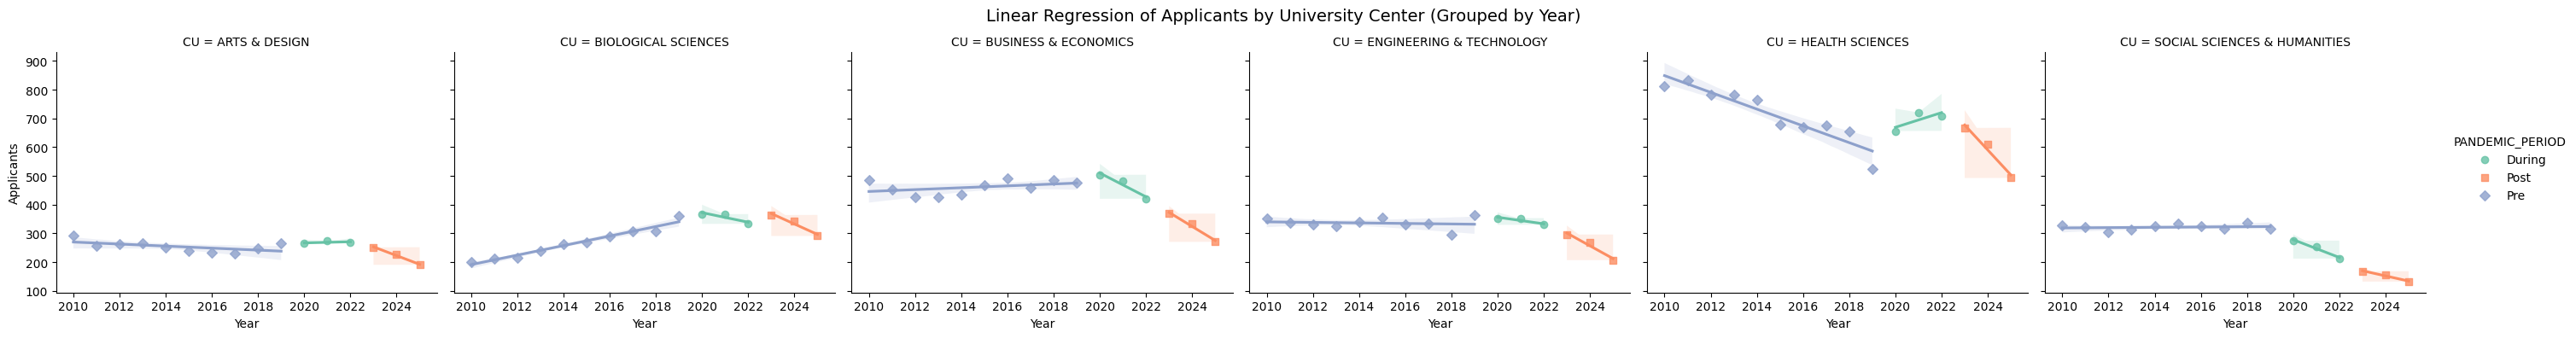

Figure 'regression_admitted_by_cu.png' saved successfully.


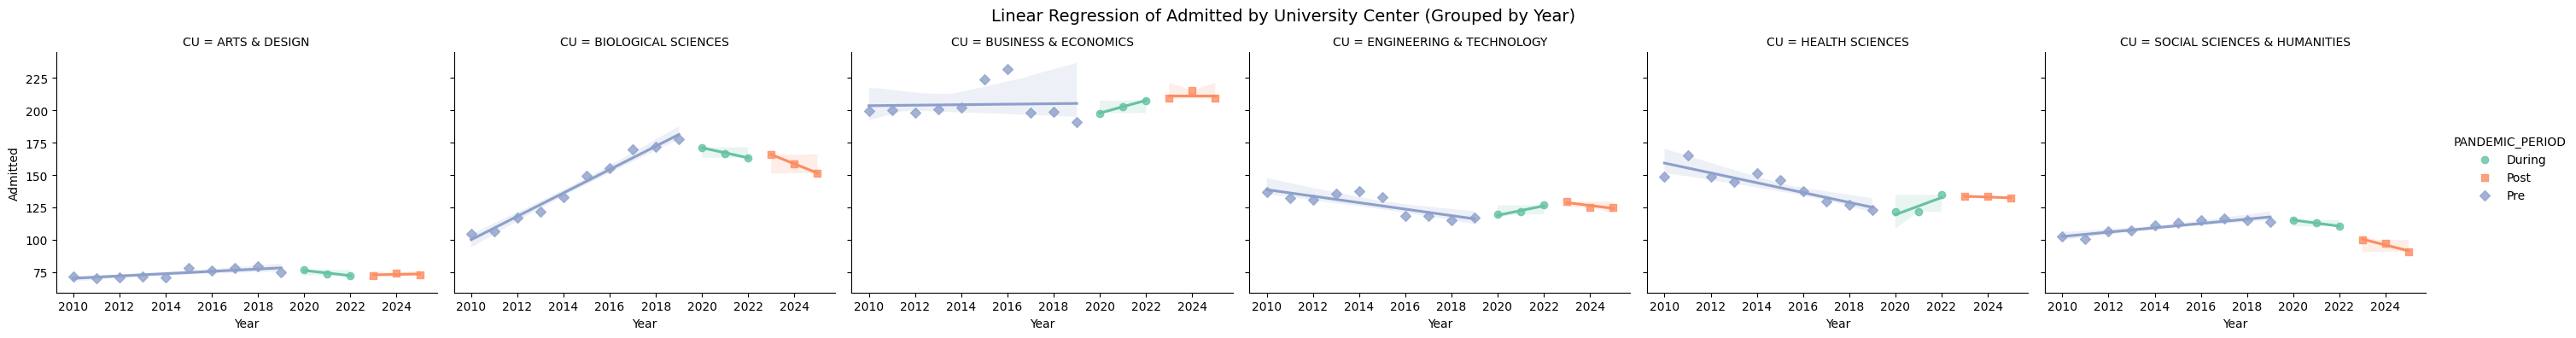

Figure 'regression_minimum_score_by_cu.png' saved successfully.


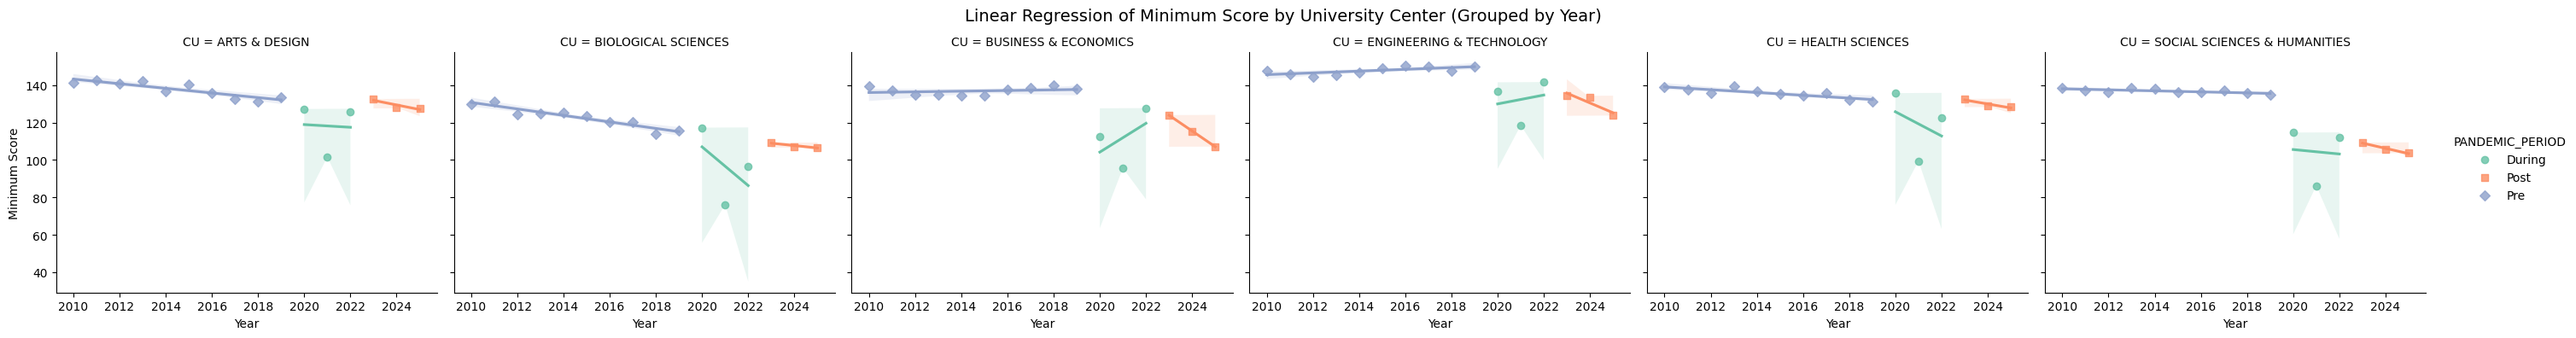

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files  # Elimina si no estás en Google Colab

# Traducir nombre de columna y valores
df_carreras["PANDEMIC_PERIOD"] = df_carreras["PERIODO_PANDEMIA"].map({
    "PRE": "Pre",
    "DURANTE": "During",
    "POST": "Post"
})

# Agrupar por CU, PANDEMIC_PERIOD y AÑO
df_cu_agg = df_carreras.groupby(['CU', 'PANDEMIC_PERIOD', 'AÑO'])[
    ['ASPIRANTES', 'ADMITIDOS', 'PUNTAJE_MINIMO']
].mean().reset_index()

# Etiquetas en inglés para los títulos
variable_labels = {
    "ASPIRANTES": "Applicants",
    "ADMITIDOS": "Admitted",
    "PUNTAJE_MINIMO": "Minimum Score"
}

# Lista para nombres de archivo
saved_files = []

# Crear, guardar y descargar los gráficos
for var, label in variable_labels.items():
    g = sns.lmplot(
        data=df_cu_agg,
        x="AÑO", y=var,
        col="CU",
        hue="PANDEMIC_PERIOD",
        height=4, aspect=1.2,
        markers=["o", "s", "D"],
        palette="Set2"
    )
    g.set_ylabels(label)
    g.set_xlabels("Year")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Linear Regression of {label} by University Center (Grouped by Year)", fontsize=14)

    file_name = f"regression_{label.lower().replace(' ', '_')}_by_cu.png"
    g.savefig(file_name, dpi=300, bbox_inches="tight")
    print(f"Figure '{file_name}' saved successfully.")
    saved_files.append(file_name)

    plt.show()

# Descargar los archivos (solo en Colab)
for file in saved_files:
    try:
        files.download(file)
        print(f"Downloading '{file}'...")
    except Exception as e:
        print(f"Error downloading '{file}': {e}")



5.4 Impacto comparativo de la pandemia (DURANTE → POST)

🎯 Objetivo general:
Medir y visualizar qué carreras y centros universitarios (CU) fueron más afectados o beneficiados después del periodo más crítico de la pandemia de COVID-19, comparando directamente el cambio entre los promedios de los semestres DURANTE y POST-pandemia.


In [ ]:
# Aseguramos que el año sea numérico
df_carreras['AÑO'] = df_carreras['AÑO'].astype(int)

# Clasificación robusta por periodo
def clasificar_periodo(año):
    if año <= 2019:
        return "PRE"
    elif 2020 <= año <= 2022:
        return "DURANTE"
    else:
        return "POST"

# Aplicamos la clasificación
df_carreras['PERIODO_PANDEMIA'] = df_carreras['AÑO'].apply(clasificar_periodo)

# Confirmamos
print("Periodos clasificados:", df_carreras['PERIODO_PANDEMIA'].unique())


Periodos clasificados: ['PRE' 'DURANTE' 'POST']


5.4a. Carreras más afectadas tras la pandemia

📈 Tipo de gráfico:
Barras horizontales apiladas (por variable), ordenadas por cambio total en la carrera.

📋 Variables analizadas:
* ASPIRANTES
* ADMITIDOS
* PUNTAJE_MINIMO

🧮 ¿Cómo se calculó?
Para cada carrera:

1. Se calculó el promedio de cada variable durante los periodos DURANTE (2020–2022) y POST (2023 en adelante).

2. Luego se restó:

POST − DURANTE

Esto da el cambio absoluto promedio en el número de aspirantes, admitidos y el puntaje mínimo.

3. Se sumaron los tres valores para obtener un indicador compuesto de cambio total.

🔎 ¿Qué revela?
Las 15 carreras con mayor caída en aspirantes, admitidos y/o puntaje mínimo, lo que sugiere una pérdida de interés o aumento de dificultad tras la pandemia.

Este gráfico muestra las 15 carreras más afectadas tras el periodo pandémico, con base en la disminución acumulada de aspirantes, admitidos y puntaje mínimo. Refleja posibles cambios de percepción o accesibilidad hacia dichas carreras.



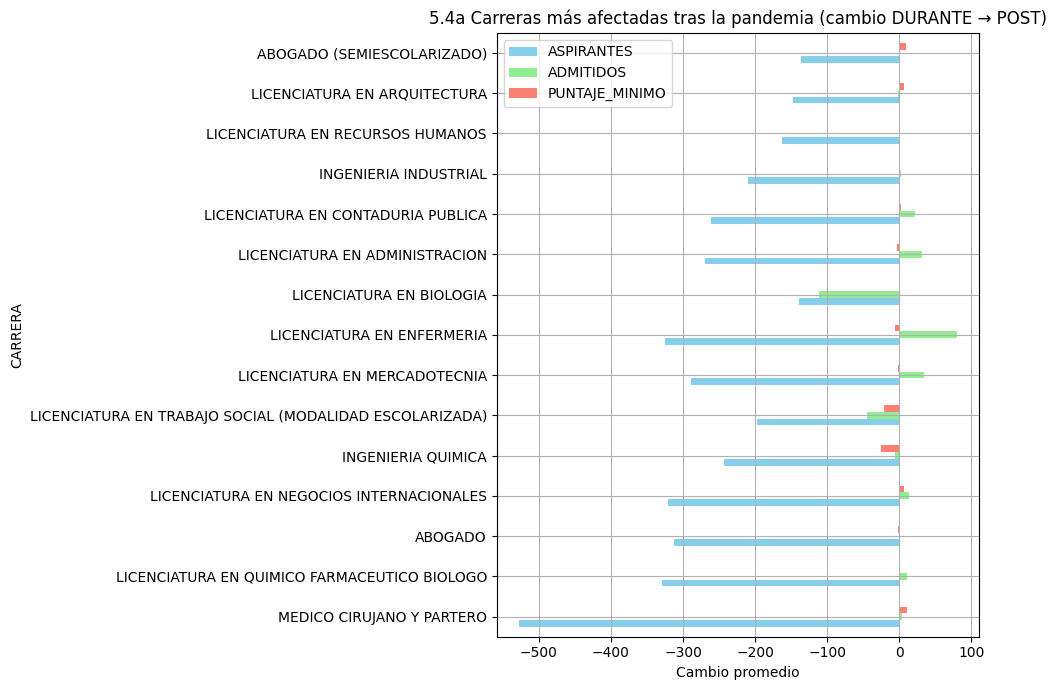

In [ ]:
# Aseguramos importación de numpy
import numpy as np

# Agrupamos y deshacemos jerarquía por PERIODO_PANDEMIA
df_variacion_carreras = df_carreras.groupby(["CARRERA", "PERIODO_PANDEMIA"])[
    ["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]
].mean().unstack(level=-1)

# Aseguramos que las columnas esperadas existan
for periodo in ["DURANTE", "POST"]:
    for var in ["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]:
        if (var, periodo) not in df_variacion_carreras.columns:
            df_variacion_carreras[(var, periodo)] = np.nan

# Calcular diferencias POST - DURANTE
diferencias_carreras = pd.DataFrame({
    "ASPIRANTES": df_variacion_carreras[("ASPIRANTES", "POST")] - df_variacion_carreras[("ASPIRANTES", "DURANTE")],
    "ADMITIDOS": df_variacion_carreras[("ADMITIDOS", "POST")] - df_variacion_carreras[("ADMITIDOS", "DURANTE")],
    "PUNTAJE_MINIMO": df_variacion_carreras[("PUNTAJE_MINIMO", "POST")] - df_variacion_carreras[("PUNTAJE_MINIMO", "DURANTE")]
})
diferencias_carreras["TOTAL_CAMBIO"] = diferencias_carreras.sum(axis=1)

# Top 15 más afectadas
top_15_caida = diferencias_carreras.sort_values("TOTAL_CAMBIO").head(15)

# Gráfica
top_15_caida[["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]].plot(
    kind="barh", figsize=(10, 7), color=["skyblue", "lightgreen", "salmon"]
)
plt.title("5.4a Carreras más afectadas tras la pandemia (cambio DURANTE → POST)")
plt.xlabel("Cambio promedio")
plt.grid(True)
plt.tight_layout()
plt.show()



🔷 5.4b. Centros universitarios más afectados tras la pandemia

📈 Tipo de gráfico:
Barras horizontales apiladas, una por CU, con colores diferenciados por variable.

📋 Variables analizadas:
* ASPIRANTES
* ADMITIDOS
* PUNTAJE_MINIMO

🧮 ¿Cómo se calculó?
Para cada CU:

1. Se obtuvo el promedio DURANTE y POST-pandemia para cada variable.

2. Se calculó la diferencia: POST − DURANTE.

3. Luego, se sumó el cambio de las tres variables para obtener una medida global del impacto.

🔎 ¿Qué revela?
Permite identificar qué centros universitarios tuvieron un retroceso significativo tras la pandemia, y en qué medida fueron afectados en términos de demanda y nivel de ingreso.


Este análisis muestra los centros universitarios que presentaron mayor disminución en aspirantes, admitidos y puntaje mínimo tras el periodo pandémico, evidenciando posibles efectos en su oferta educativa o percepción institucional.



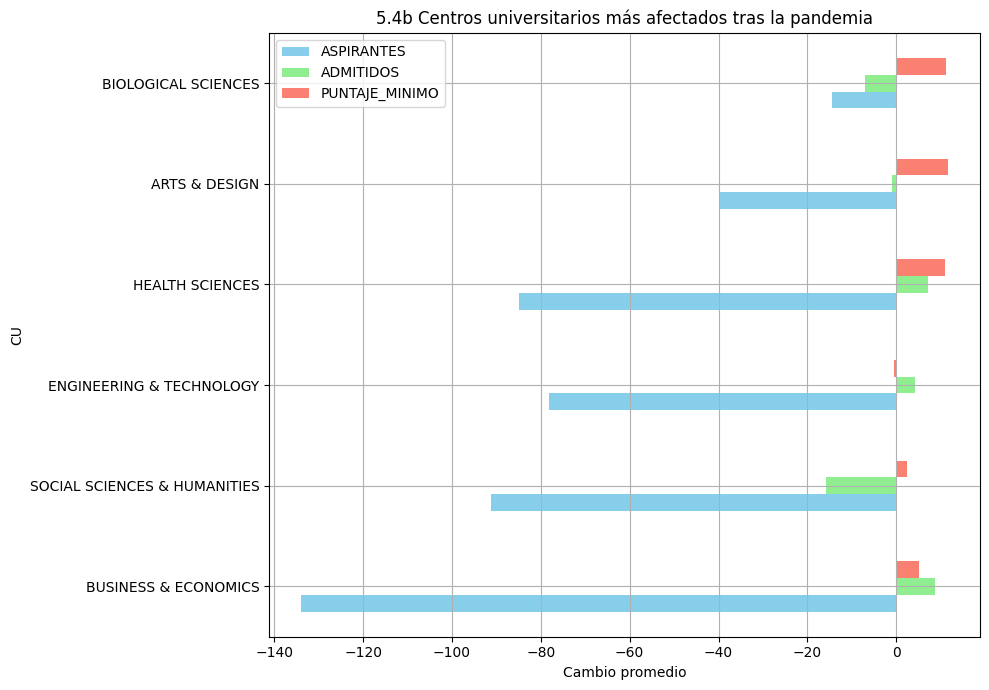

In [ ]:
# Agrupamos por CU y PERIODO_PANDEMIA
df_variacion_cu = df_carreras.groupby(["CU", "PERIODO_PANDEMIA"])[
    ["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]
].mean().unstack(level=-1)

# Aseguramos que existan
for periodo in ["DURANTE", "POST"]:
    for var in ["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]:
        if (var, periodo) not in df_variacion_cu.columns:
            df_variacion_cu[(var, periodo)] = np.nan

# Calcular diferencias
diferencias_cu = pd.DataFrame({
    "ASPIRANTES": df_variacion_cu[("ASPIRANTES", "POST")] - df_variacion_cu[("ASPIRANTES", "DURANTE")],
    "ADMITIDOS": df_variacion_cu[("ADMITIDOS", "POST")] - df_variacion_cu[("ADMITIDOS", "DURANTE")],
    "PUNTAJE_MINIMO": df_variacion_cu[("PUNTAJE_MINIMO", "POST")] - df_variacion_cu[("PUNTAJE_MINIMO", "DURANTE")]
})
diferencias_cu["TOTAL_CAMBIO"] = diferencias_cu.sum(axis=1)

# Ordenar y graficar
diferencias_cu.sort_values("TOTAL_CAMBIO")[["ASPIRANTES", "ADMITIDOS", "PUNTAJE_MINIMO"]].plot(
    kind="barh", figsize=(10, 7), color=["skyblue", "lightgreen", "salmon"]
)
plt.title("5.4b Centros universitarios más afectados tras la pandemia")
plt.xlabel("Cambio promedio")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🟪 SECCIÓN 6. Distribuciones y correlaciones

6.1 Distribución por CU (Violin plot)

🎯 Objetivo:
Visualizar cómo se distribuyen los puntajes mínimos o el número de aspirantes por centro universitario (CU), mostrando no solo promedios, sino también forma y dispersión de la distribución.

📈 Tipo de gráfico:
Violin Plot — combina boxplot + distribución KDE.

📋 Variables clave:
* CU
* PUNTAJE_MINIMO
* ASPIRANTES

🔎 ¿Qué revela?
Este gráfico permite observar:
Qué CU tienen mayor concentración de puntajes bajos o altos. Si hay asimetrías en la distribución. CU con alta varianza o casos atípicos.

Link para interpretarlos: https://www.youtube.com/watch?v=Rw00VmP--qk

<ipython-input-91-4231255547>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_carreras, x="CU", y="PUNTAJE_MINIMO", palette="Set3", inner="box")


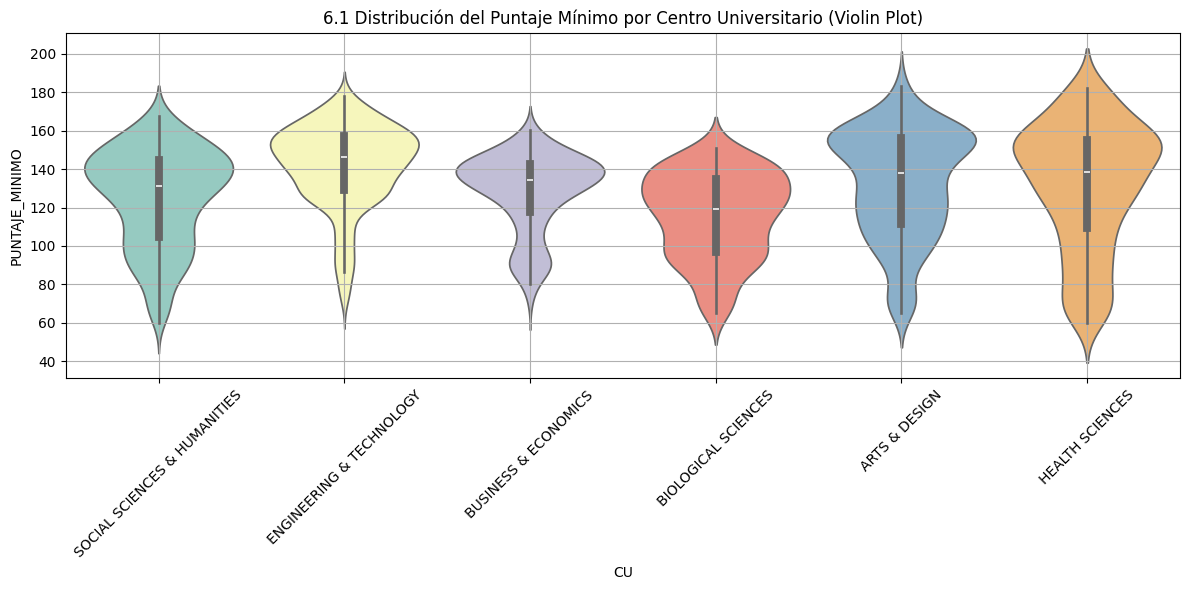

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_carreras, x="CU", y="PUNTAJE_MINIMO", palette="Set3", inner="box")
plt.title("6.1 Distribución del Puntaje Mínimo por Centro Universitario (Violin Plot)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-92-1872539650>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_carreras, x="CU", y="ASPIRANTES", palette="coolwarm", inner="quartile")


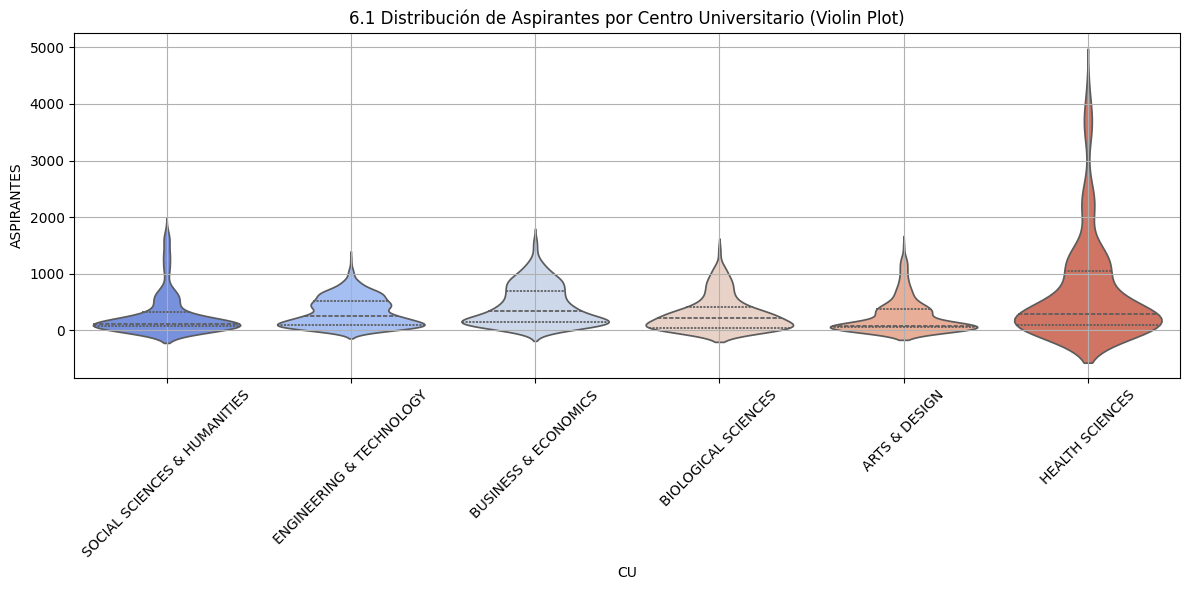

In [ ]:
# Violin para aspirantes
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_carreras, x="CU", y="ASPIRANTES", palette="coolwarm", inner="quartile")
plt.title("6.1 Distribución de Aspirantes por Centro Universitario (Violin Plot)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


6.2 Matriz de correlación

🎯 Objetivo:
Explorar correlaciones estadísticas entre las variables clave del sistema: cuántos aspirantes ingresan, cuál es su puntaje y cómo se relacionan entre sí.

📊 Tipo de gráfico:
Mapa de calor (Heatmap) de correlaciones.

📋 Variables clave:
* ASPIRANTES
* ADMITIDOS
* TASA_DEMANDA
* PUNTAJE_MINIMO

🔎 ¿Qué revela?
Si hay una relación lineal entre demanda y puntaje mínimo. Qué tan fuerte es la correlación entre el número de admitidos y los aspirantes. Posibles redundancias o dependencia entre variables.

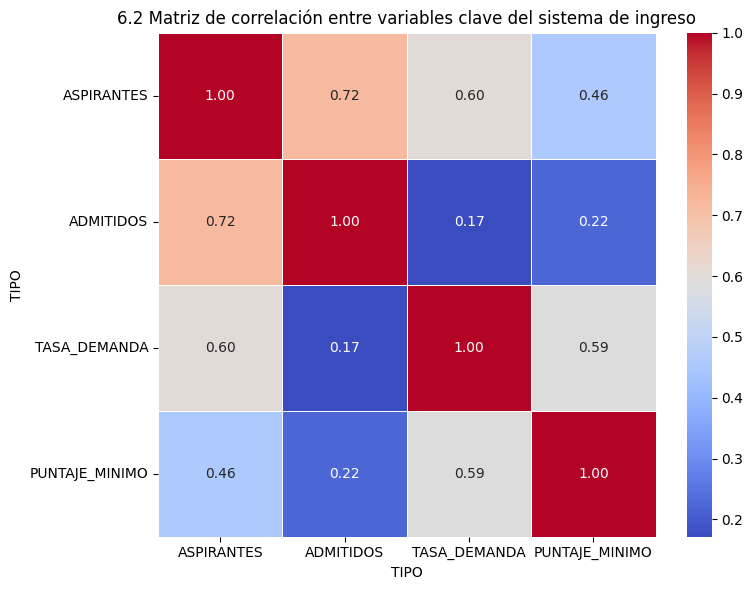

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtramos solo columnas numéricas relevantes
variables_corr = df_carreras[["ASPIRANTES", "ADMITIDOS", "TASA_DEMANDA", "PUNTAJE_MINIMO"]]

# Calculamos matriz de correlación
matriz_corr = variables_corr.corr()

# Graficamos heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("6.2 Matriz de correlación entre variables clave del sistema de ingreso")
plt.tight_layout()
plt.show()


##🟨 SECCIÓN 7. Segmentación y Clusters

🎯 Objetivo:
Agrupar las carreras de acuerdo a su comportamiento en variables clave de ingreso como aspirantes, admitidos, tasa de demanda y puntaje mínimo, con el fin de identificar perfiles comunes de carrera:

* Altamente competitivas
* Intermedias
* Baja demanda o accesibilidad

📋 Variables utilizadas:
* ASPIRANTES
* ADMITIDOS
* TASA_DEMANDA (calculada como ASPIRANTES / ADMITIDOS)
* PUNTAJE_MINIMO

⚙️ Metodología:
1. Estandarización de variables: Se normalizan para evitar que una variable domine por su escala.

2. Reducción de dimensionalidad con PCA:

* PCA1 representa la demanda general (aspirantes/admitidos).

* PCA2 representa la selectividad o dificultad de ingreso (puntaje mínimo).

3. Agrupamiento (KMeans): Se generan 3 grupos con base en las variables estandarizadas.



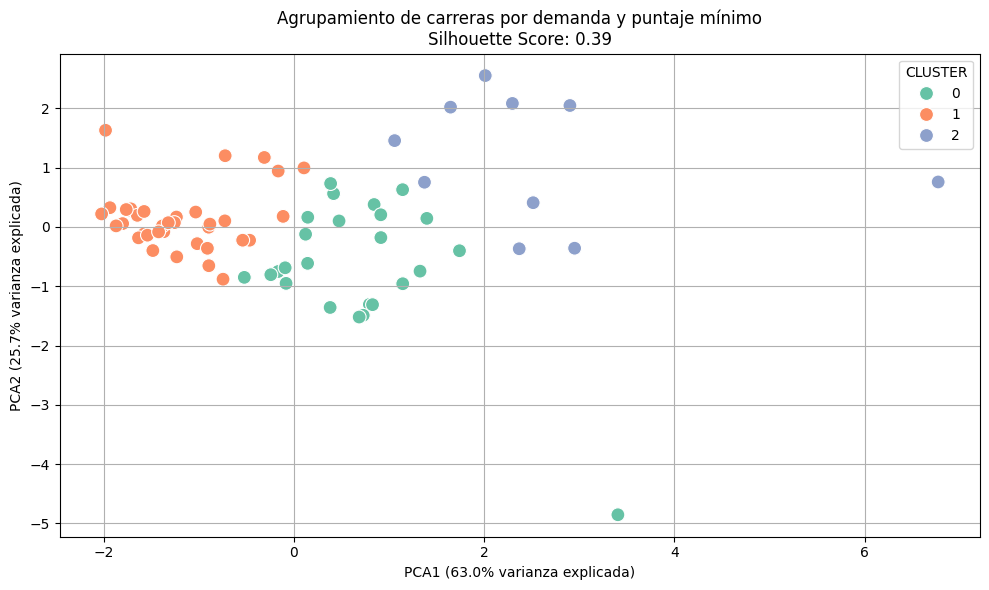

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar cálculo de TASA_DEMANDA
if 'TASA_DEMANDA' not in df_carreras.columns:
    df_carreras["TASA_DEMANDA"] = df_carreras["ASPIRANTES"] / df_carreras["ADMITIDOS"]

# Promedios por carrera
df_cluster = df_carreras.groupby("CARRERA")[
    ["ASPIRANTES", "ADMITIDOS", "TASA_DEMANDA", "PUNTAJE_MINIMO"]
].mean()

# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Reducción de dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_ * 100  # porcentaje

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Cálculo del Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)

# DataFrame PCA con clusters
df_cluster_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=df_cluster.index)
df_cluster_pca["CLUSTER"] = clusters

# Gráfica con etiquetas mejoradas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster_pca,
    x="PCA1", y="PCA2", hue="CLUSTER", palette="Set2", s=100
)
plt.title(f"Agrupamiento de carreras por demanda y puntaje mínimo\nSilhouette Score: {sil_score:.2f}")
plt.xlabel(f"PCA1 ({explained_var[0]:.1f}% varianza explicada)")
plt.ylabel(f"PCA2 ({explained_var[1]:.1f}% varianza explicada)")
plt.grid(True)
plt.tight_layout()
plt.show()



Interpretación de los Clusters
📌 Cluster 0:
* Carreras con menor número de aspirantes y puntajes bajos
* Accesibles o de menor demanda

📌 Cluster 1:
* Carreras de demanda y dificultad intermedia
* Perfil mixto

📌 Cluster 2:
* Carreras muy solicitadas y con puntajes mínimos altos
* Alta selectividad, como medicina o ingenierías populares

In [ ]:
import pandas as pd

# Guardamos resultados
df_resultados_cluster = df_cluster.copy()
df_resultados_cluster[["PCA1", "PCA2", "CLUSTER"]] = df_cluster_pca[["PCA1", "PCA2", "CLUSTER"]]

# Mostramos tabla ordenada
df_resultados_cluster_sorted = df_resultados_cluster.sort_values("CLUSTER")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

display(df_resultados_cluster_sorted)



TIPO                                               ASPIRANTES   ADMITIDOS  \
CARRERA                                                                     
ABOGADO (SEMIESCOLARIZADO)                         489.903226  193.935484   
INGENIERIA BIOMEDICA                               263.064516   77.354839   
INGENIERIA CIVIL                                   570.935484  133.483871   
INGENIERIA EN COMPUTACION                          598.806452  237.645161   
INGENIERIA INFORMATICA                             415.483871  213.903226   
...                                                       ...         ...   
LICENCIATURA EN MEDICINA VETERINARIA Y ZOOTECNIA   791.354839  243.064516   
LICENCIATURA EN PSICOLOGIA                        1243.741935  204.580645   
LICENCIATURA EN ENFERMERIA                        1190.032258  248.741935   
LICENCIATURA EN ADMINISTRACION                     833.483871  375.548387   
MEDICO CIRUJANO Y PARTERO                         2962.516129  350.677419   

TIPO                                              TASA_DEMANDA  \
CARRERA                                                          
ABOGADO (SEMIESCOLARIZADO)                            2.553702   
INGENIERIA BIOMEDICA                                  3.485404   
INGENIERIA CIVIL                                      4.279240   
INGENIERIA EN COMPUTACION                             2.617576   
INGENIERIA INFORMATICA                                1.908120   
...                                                        ...   
LICENCIATURA EN MEDICINA VETERINARIA Y ZOOTECNIA      3.220707   
LICENCIATURA EN PSICOLOGIA                            6.065356   
LICENCIATURA EN ENFERMERIA                            5.091059   
LICENCIATURA EN ADMINISTRACION                        2.245781   
MEDICO CIRUJANO Y PARTERO                             8.464882   

TIPO                                              PUNTAJE_MINIMO      PCA1  \
CARRERA                                                                      
ABOGADO (SEMIESCOLARIZADO)                            130.682123  0.418058   
INGENIERIA BIOMEDICA                                  166.202910  0.794639   
INGENIERIA CIVIL                                      155.886145  1.326996   
INGENIERIA EN COMPUTACION                             144.771626  1.143885   
INGENIERIA INFORMATICA                                135.124226  0.387024   
...                                                          ...       ...   
LICENCIATURA EN MEDICINA VETERINARIA Y ZOOTECNIA      138.363726  1.373764   
LICENCIATURA EN PSICOLOGIA                            158.054523  2.952109   
LICENCIATURA EN ENFERMERIA                            145.458858  2.516246   
LICENCIATURA EN ADMINISTRACION                        133.355642  1.647749   
MEDICO CIRUJANO Y PARTERO                             174.564352  6.774331   

TIPO                                                  PCA2  CLUSTER  
CARRERA                                                              
ABOGADO (SEMIESCOLARIZADO)                        0.561708        0  
INGENIERIA BIOMEDICA                             -1.308039        0  
INGENIERIA CIVIL                                 -0.745749        0  
INGENIERIA EN COMPUTACION                         0.628058        0  
INGENIERIA INFORMATICA                            0.731701        0  
...                                                    ...      ...  
LICENCIATURA EN MEDICINA VETERINARIA Y ZOOTECNIA  0.753307        2  
LICENCIATURA EN PSICOLOGIA                       -0.359045        2  
LICENCIATURA EN ENFERMERIA                        0.408364        2  
LICENCIATURA EN ADMINISTRACION                    2.019761        2  
MEDICO CIRUJANO Y PARTERO                         0.758034        2  

[71 rows x 7 columns]

## 🟥 Sección 8. Detección de Outliers

🎯 Objetivo:

Identificar carreras atípicas cuyas métricas de ingreso se alejan significativamente del comportamiento general. Esto puede reflejar situaciones como:

* Carreras con demanda inusualmente alta o baja
* Carreras con puntajes mínimos extremos
* Posibles errores o valores a verificar

📋 Variables evaluadas:
* ASPIRANTES
* ADMITIDOS
* TASA_DEMANDA
* PUNTAJE_MINIMO

🔬 Metodología:
Se aplica el criterio de IQR (Interquartile Range) para cada variable:

Outliers se definen como aquellos valores fuera del rango:
Q1 - 1.5 × IQR o Q3 + 1.5 × IQR

In [ ]:
def detectar_outliers_iqr(df, columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

# Aplicamos por variable (por promedio de carrera)
df_promedios = df_carreras.groupby("CARRERA")[["ASPIRANTES", "ADMITIDOS", "TASA_DEMANDA", "PUNTAJE_MINIMO"]].mean()

outliers_aspirantes = detectar_outliers_iqr(df_promedios, "ASPIRANTES")
outliers_admitidos = detectar_outliers_iqr(df_promedios, "ADMITIDOS")
outliers_td = detectar_outliers_iqr(df_promedios, "TASA_DEMANDA")
outliers_pm = detectar_outliers_iqr(df_promedios, "PUNTAJE_MINIMO")


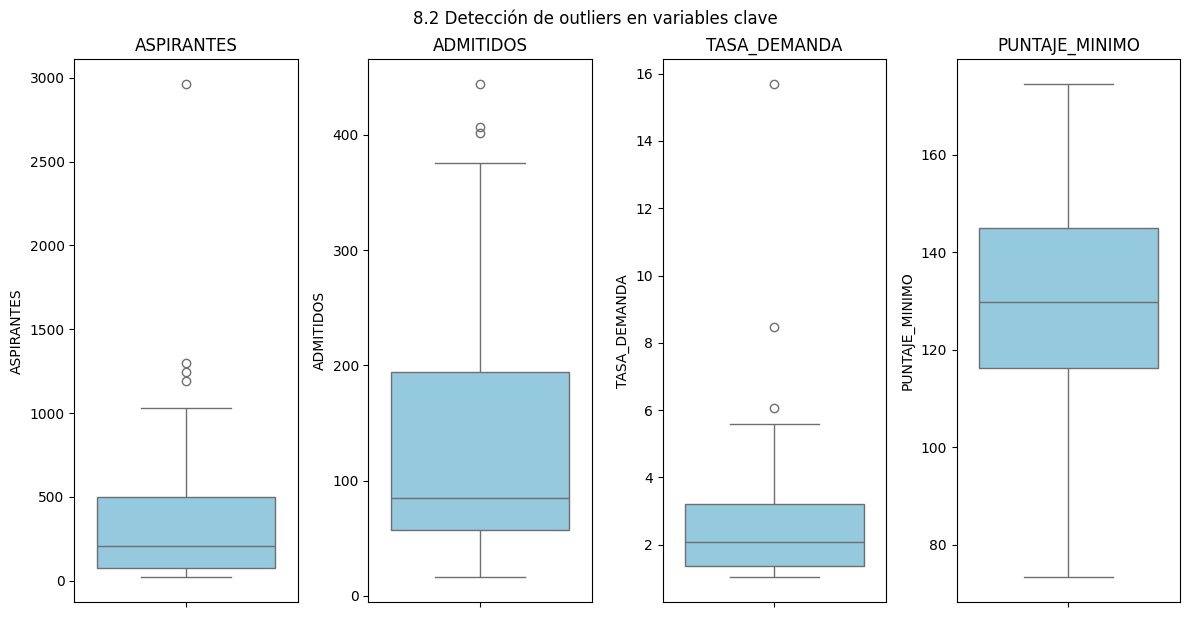

In [ ]:
# 8.2 Visualización de outliers por variable
import matplotlib.pyplot as plt
import seaborn as sns

variables = ["ASPIRANTES", "ADMITIDOS", "TASA_DEMANDA", "PUNTAJE_MINIMO"]
plt.figure(figsize=(12, 6))
for i, var in enumerate(variables):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_promedios[var], color="skyblue")
    plt.title(var)
    plt.tight_layout()
plt.suptitle("8.2 Detección de outliers en variables clave", y=1.02)
plt.show()


#PASO 3. Modelos Predictivos y Perfiles de Carrera

##Predicción Interactiva de Aspirantes y Admitidos con Series de Tiempo (Prophet)

📌 Objetivo: Estimar la cantidad futura de aspirantes y admitidos por carrera y centro universitario, a partir de datos históricos y modelos de series de tiempo.

Modelo utilizado: Facebook Prophet (Series de tiempo con componentes de tendencia, estacionalidad y eventos).

Variables de entrada:
* Fecha (ds generada a partir del PERIODO)
* CU
* CARRERA
* ASPIRANTES
* ADMITIDOS

Variables a predecir:
* ASPIRANTES
* ADMITIDOS

Interfaz: Menús interactivos permiten seleccionar CU, carrera y número de semestres a predecir.

Tendencias futuras por programa académico y centro, útiles para la planeación de admisiones, promoción universitaria, y asignación de recursos institucionales.

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 0. Crear columna 'ds' a partir de PERIODO        ║
# ╚══════════════════════════════════════════════════╝
# (ejecuta esto una sola vez, antes de usar Prophet o groupby("ds"))

def periodo_to_date(periodo):
    """
    Convierte un string 'YYYYA' o 'YYYYB' en la fecha del inicio
    del semestre correspondiente (A = 1-ene, B = 1-jul).
    """
    try:
        year = int(periodo[:4])
        ciclo = periodo[4].upper()
        return pd.to_datetime(f"{year}-01-01") if ciclo == "A" else pd.to_datetime(f"{year}-07-01")
    except Exception:
        return pd.NaT            # Devuelve NaT si el formato no es válido

# Generar la nueva columna
df_carreras["ds"] = df_carreras["PERIODO"].apply(periodo_to_date)

# Eliminar filas que no se pudieron convertir
df_carreras = df_carreras.dropna(subset=["ds"])


In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 1. Imports y configuración general               ║
# ╚══════════════════════════════════════════════════╝
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import ipywidgets as widgets
from ipywidgets import interactive, Dropdown, FloatSlider
from IPython.display import display, clear_output



Aquí se definen dos funciones principales:

***train_prophet_model(ts_df):*** Recibe un DataFrame con dos columnas obligatorias (ds como fecha y y como variable a predecir) y entrena un modelo Prophet sobre esos datos. El modelo identifica automáticamente patrones de tendencia, estacionalidad y posibles rupturas estructurales.

***predict_prophet(model, periods):*** Toma un modelo Prophet ya entrenado y genera predicciones a futuro, para el número de semestres que el usuario especifique. Utiliza una frecuencia de 6 meses (un semestre académico) y devuelve un DataFrame con fechas, valores pronosticados y sus intervalos de confianza.

Estas funciones encapsulan la lógica del modelo para que puedan ser reutilizadas fácilmente en distintos escenarios (por CU, por carrera o por UDG total).

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 2. Funciones auxiliares: Prophet                 ║
# ╚══════════════════════════════════════════════════╝
def train_prophet_model(ts_df):
    """
    Entrena un modelo Prophet con columnas ['ds','y'].
    """
    model = Prophet()
    model.fit(ts_df)
    return model

def predict_prophet(model, periods):
    """
    Devuelve pronóstico a 'periods' semestres a futuro.
    """
    future = model.make_future_dataframe(periods=periods, freq="6MS")  # 6 meses ≈ 1 semestre
    forecast = model.predict(future)
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]




En esta parte, se construye una visión general del comportamiento histórico de aspirantes y admitidos en toda la Universidad:

1. Se agrupan los datos por fecha (ds) y se suman los valores de aspirantes y admitidos.

2. Se renombra cada variable como y, para cumplir con el formato requerido por Prophet.

3. Se entrenan dos modelos Prophet: uno para aspirantes y otro para admitidos.

4. Finalmente, se generan predicciones para los próximos 4 semestres (2 años).

Esta sección proporciona una base de referencia global que puede usarse cuando no se desea filtrar por centro o carrera.

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 3. Modelos y pronósticos UDG total               ║
# ╚══════════════════════════════════════════════════╝
df_udg_ts = (
    df_carreras
    .groupby("ds")[["ASPIRANTES", "ADMITIDOS"]]
    .sum()
    .reset_index()
)

# DataFrames para Prophet
df_udg_asp = df_udg_ts.rename(columns={"ASPIRANTES": "y"})[["ds", "y"]]
df_udg_adm = df_udg_ts.rename(columns={"ADMITIDOS": "y"})[["ds", "y"]]

model_udg_asp = train_prophet_model(df_udg_asp)
model_udg_adm = train_prophet_model(df_udg_adm)

# Pronóstico inicial: 4 semestres (≈ 2 años)
forecast_udg_asp = predict_prophet(model_udg_asp, periods=4)
forecast_udg_adm = predict_prophet(model_udg_adm, periods=4)




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzhymq1z/zzeqkb5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzhymq1z/dib1ykx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42563', 'data', 'file=/tmp/tmpjzhymq1z/zzeqkb5g.json', 'init=/tmp/tmpjzhymq1z/dib1ykx_.json', 'output', 'file=/tmp/tmpjzhymq1z/prophet_modelzog95p7p/prophet_model-20250615233422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Esta función (plot_predictions) permite generar predicciones ajustadas según los filtros que seleccione el usuario:

* Si no se selecciona ningún filtro (Todos los Centros, Todas las Carreras), se muestran las predicciones globales del Paso 3.

* Si se elige un CU o una carrera, se filtran los datos correspondientes, se agrupan por fecha y se entrena un nuevo modelo Prophet sobre esos datos específicos.

* En caso de no existir información histórica suficiente, se muestra un mensaje de advertencia.

* Si hay datos disponibles, se muestra la tabla de predicciones para aspirantes y admitidos, y se grafican las curvas generadas por el modelo.

Esta sección permite analizar con precisión la evolución de la demanda académica y sugiere posibles escenarios futuros.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatSlider, interactive
from IPython.display import display, clear_output

cu_options = ["Todos los Centros"] + sorted(df_carreras["CU"].dropna().unique())
carrera_options = ["Todas las Carreras"] + sorted(df_carreras["CARRERA"].dropna().unique())

cu_dropdown = Dropdown(options=cu_options, description="Centro:")
carrera_dropdown = Dropdown(options=carrera_options, description="Carrera:")
periods_slider = FloatSlider(min=1, max=10, step=1, value=4, description="Semestres:")

def plot_predictions(selected_cu, selected_carrera, periods_to_predict):
    clear_output(wait=True)
    display(cu_dropdown, carrera_dropdown, periods_slider)

    if selected_cu == "Todos los Centros" and selected_carrera == "Todas las Carreras":
        print(f"🔮 UDG Total – Próximos {int(periods_to_predict)} semestres")
        display(forecast_udg_asp.head(int(periods_to_predict)))
        display(forecast_udg_adm.head(int(periods_to_predict)))
        model_udg_asp.plot(forecast_udg_asp); plt.title("Aspirantes UDG"); plt.show()
        model_udg_adm.plot(forecast_udg_adm); plt.title("Admitidos UDG"); plt.show()
        return

    if selected_carrera == "Todas las Carreras":
        filtro = df_carreras["CU"] == selected_cu
        etiqueta = f"CU: {selected_cu}"
    elif selected_cu == "Todos los Centros":
        filtro = df_carreras["CARRERA"] == selected_carrera
        etiqueta = f"Carrera: {selected_carrera}"
    else:
        filtro = (df_carreras["CU"] == selected_cu) & (df_carreras["CARRERA"] == selected_carrera)
        etiqueta = f"{selected_carrera} en {selected_cu}"

    df_ts = (
        df_carreras[filtro]
        .groupby("ds")[["ASPIRANTES", "ADMITIDOS"]]
        .sum()
        .reset_index()
    )

    if df_ts.empty:
        print(f"No hay datos históricos para {etiqueta}.")
        return

    df_asp = df_ts.rename(columns={"ASPIRANTES": "y"})[["ds", "y"]]
    df_adm = df_ts.rename(columns={"ADMITIDOS": "y"})[["ds", "y"]]

    m_asp = train_prophet_model(df_asp)
    m_adm = train_prophet_model(df_adm)

    fcst_asp = predict_prophet(m_asp, int(periods_to_predict))
    fcst_adm = predict_prophet(m_adm, int(periods_to_predict))

    print(f"🔮 Aspirantes – {etiqueta}")
    display(fcst_asp.head(int(periods_to_predict)))
    print(f"🔮 Admitidos – {etiqueta}")
    display(fcst_adm.head(int(periods_to_predict)))

    m_asp.plot(fcst_asp); plt.title(f"Aspirantes • {etiqueta}"); plt.show()
    m_adm.plot(fcst_adm); plt.title(f"Admitidos  • {etiqueta}"); plt.show()


En esta última parte se construye la interfaz visual:

Se definen tres controles:

* Dropdown de Centro Universitario (CU)

* Dropdown de Carrera

* Slider para elegir el número de semestres a predecir

Se conectan estos controles a la función plot_predictions usando ipywidgets.interactive().

Cada vez que el usuario cambia una selección, la función se ejecuta automáticamente y actualiza los resultados y gráficos.

In [ ]:
interactive_plot = interactive(
    plot_predictions,
    selected_cu=cu_dropdown,
    selected_carrera=carrera_dropdown,
    periods_to_predict=periods_slider,
)

display(interactive_plot)


interactive(children=(Dropdown(description='Centro:', options=('Todos los Centros', 'ARTS & DESIGN', 'BIOLOGIC…

##Modelado Predictivo de Tasa de Admisión



📌 Objetivo:

Predecir la TASA_DE_ADMISION usando variables como PUNTAJE_MINIMO, ASPIRANTES, TASA_DEMANDA, CARRERA, CU y AÑO. Esto permitirá conocer qué factores tienen más peso en la probabilidad de ser admitido.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import pandas as pd

# Variables
features = ["PUNTAJE_MINIMO", "ASPIRANTES", "TASA_DEMANDA", "CARRERA", "CU", "AÑO"]
target = "TASA_ADMISION"

# Filtrar datos válidos
df_model = df_carreras.dropna(subset=features + [target])

# Separar entrada y salida
X = df_model[features]
y = df_model[target]

# Columnas categóricas
cat_cols = ["CARRERA", "CU"]

# Preprocesamiento con One-Hot Encoding para variables categóricas
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model_lr = make_pipeline(preprocessor, LinearRegression())
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Regresión Lineal:")
print("R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Regresión Lineal:
R²: 0.8812956989164052
RMSE: 0.1003269103287244


In [ ]:
from sklearn.tree import DecisionTreeRegressor

model_tree = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=5, random_state=42))
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

print("Árbol de Decisión:")
print("R²:", r2_score(y_test, y_pred_tree))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Árbol de Decisión:
R²: 0.9989814708786898
RMSE: 0.1003269103287244


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest:")
print("R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Random Forest:
R²: 0.9999917731470622
RMSE: 0.1003269103287244


Random Forest, al ser un conjunto de múltiples árboles, también obtiene un R² cercano a 1.0, lo que indica un excelente poder predictivo. Mantiene el mismo RMSE, lo que sugiere robustez pero también que los errores son similares en magnitud para todos los modelos.

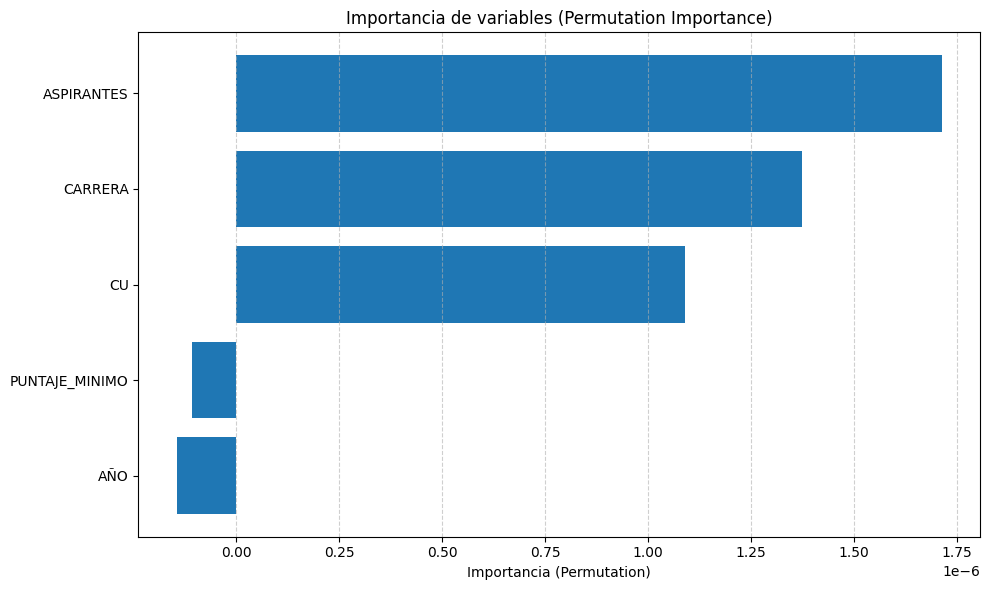

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Ejecutar permutation importance directamente sobre el pipeline
perm = permutation_importance(
    model_rf, X_test, y_test,
    n_repeats=20, random_state=42, n_jobs=-1
)

# 2. Usar nombres originales de columnas (sin codificación)
feature_names_orig = X_test.columns

# 3. Crear DataFrame de importancias
df_perm = pd.DataFrame({
    "Variable": feature_names_orig,
    "Importancia": perm.importances_mean
}).sort_values("Importancia", ascending=False)

# 4. Opcional: excluir TASA_DEMANDA si deseas evitar que opaque el resto
df_perm = df_perm[df_perm["Variable"] != "TASA_DEMANDA"]

# 5. Gráfica
plt.figure(figsize=(10, 6))
plt.barh(df_perm["Variable"][:15][::-1], df_perm["Importancia"][:15][::-1])
plt.xlabel("Importancia (Permutation)")
plt.title("Importancia de variables (Permutation Importance)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Este gráfico muestra el impacto relativo que cada variable tiene en la predicción de la tasa de admisión, utilizando el método de Permutation Importance, que evalúa cuánto empeora el modelo cuando se desordena una variable.

Observaciones clave:
* ASPIRANTES es la variable con mayor influencia en la tasa de admisión, lo que sugiere que el tamaño de la demanda absoluta afecta directamente la proporción de estudiantes que logran ingresar.

* CARRERA y CU (Centro Universitario) también tienen importancia considerable, lo que refleja que la estructura institucional y la oferta académica afectan las oportunidades de admisión.

* PUNTAJE_MINIMO y AÑO tienen un impacto mucho menor en la predicción. Esto podría deberse a que el puntaje no varía tanto entre ciclos, o a que su efecto ya está implícito en la demanda y distribución por carrera.

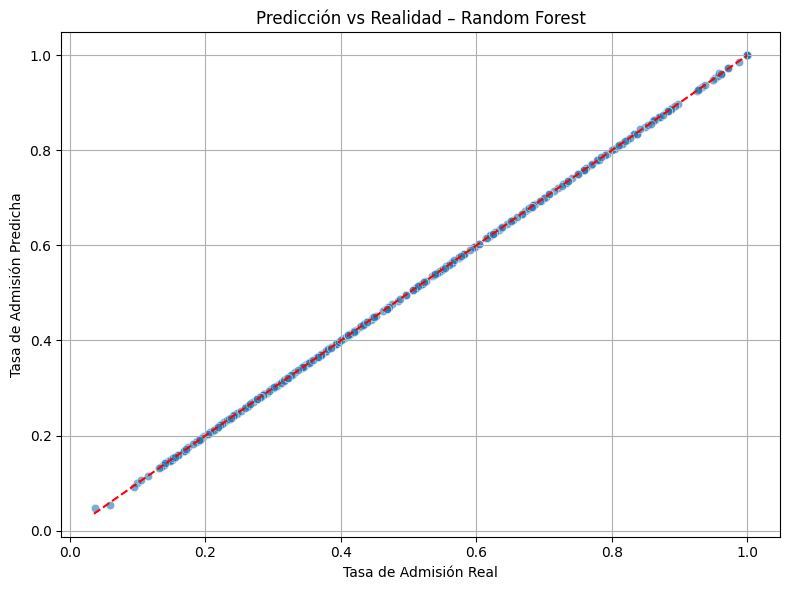

In [ ]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # línea de referencia
plt.xlabel("Tasa de Admisión Real")
plt.ylabel("Tasa de Admisión Predicha")
plt.title("Predicción vs Realidad – Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()


Este gráfico compara las tasas de admisión reales (eje X) con las tasas predichas por el modelo (eje Y). La línea roja punteada representa una predicción perfecta (Y = X), es decir, cuando el valor predicho es igual al real.

Los puntos se alinean casi perfectamente sobre la diagonal, lo cual indica que el modelo tiene altísima precisión. No se observan desviaciones sistemáticas ni sesgos, ni en los valores bajos (carreras de alta competencia) ni en los altos (carreras con baja demanda). Esto confirma que el modelo de Random Forest está capturando correctamente las relaciones no lineales y las interacciones entre variables.

##Clasificación de Carreras o Centros según Competitividad con K-Means Clustering

Objetivo:

Clasificar automáticamente las carreras de la Universidad de Guadalajara en niveles de alta, media o baja competitividad, a partir de sus características históricas. Esta clasificación es útil para aplicar estrategias diferenciadas de promoción, ajuste de cupos o análisis institucional.

Modelo utilizado:

K-Means Clustering, un algoritmo no supervisado de agrupamiento que permite detectar similitudes entre carreras sin necesidad de etiquetas previas.

Variables utilizadas como entrada (features):
* PUNTAJE_MINIMO (promedio por carrera)
* TASA_DEMANDA (aspirantes / cupo ofertado)
* TASA_ADMISION (admitidos / aspirantes)
* RELACION_AS_AD (aspirantes / admitidos)

Estas variables permiten capturar distintos aspectos de la competitividad, combinando requisitos de ingreso, presión de demanda y exclusividad del acceso.

Resultado esperado:
Asignación automática de etiquetas de competitividad para cada carrera:

* Alta Competitividad
* Media Competitividad
* Baja Competitividad


Preparación de datos:
Se parte de un conjunto de datos que contiene información histórica por carrera, como el puntaje mínimo requerido, número de aspirantes, admitidos y tasas derivadas.

Para asegurar la calidad del análisis:

*   Se eliminan registros con datos faltantes en las variables clave.

*   Se agrupan los datos por nombre de carrera, calculando el promedio histórico de cada variable, con el fin de obtener un perfil representativo por programa académico.
*   Se crea una nueva variable derivada: la relación aspirantes/admitidos, que captura directamente la presión por ingresar.

*   Finalmente, se normalizan todas las variables numéricas mediante StandardScaler, lo que estandariza la escala y evita que alguna variable domine el proceso de agrupamiento debido a diferencias de magnitud.



In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 1. Preparación de datos                          ║
# ╚══════════════════════════════════════════════════╝
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Selecciona variables relevantes
features_cluster = ["PUNTAJE_MINIMO", "TASA_DEMANDA", "TASA_ADMISION", "ASPIRANTES", "ADMITIDOS"]

# Filtra filas sin nulos en las columnas clave y calcula promedio por carrera
df_carreras_avg = (
    df_carreras
    .dropna(subset=features_cluster)
    .groupby("CARRERA")[features_cluster]
    .mean()
)

# Variable derivada: relación Aspirantes / Admitidos
df_carreras_avg["RELACION_AS_AD"] = df_carreras_avg["ASPIRANTES"] / df_carreras_avg["ADMITIDOS"]

# Matriz final de features para clustering
features_final = ["PUNTAJE_MINIMO", "TASA_DEMANDA", "TASA_ADMISION", "RELACION_AS_AD"]
X = df_carreras_avg[features_final]

# Escalado (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Una vez preparados y escalados los datos, se aplica el algoritmo de K-Means Clustering con k=3, lo que agrupa automáticamente las carreras en tres segmentos distintos, cada uno con características internas similares.

* K-Means funciona encontrando centroides que representan el “centro” de cada grupo.
* Cada carrera es asignada al clúster cuyo centro está más cerca en el espacio de características.
* Este paso produce una etiqueta numérica (0, 1, 2) que identifica a qué grupo pertenece cada carrera.

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 2. Clustering K-Means                            ║
# ╚══════════════════════════════════════════════════╝
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_carreras_avg["CLUSTER"] = kmeans.fit_predict(X_scaled)

# Resumen de centroides en espacio original (promedio por cluster)
cluster_summary = (
    df_carreras_avg
    .groupby("CLUSTER")[features_final]
    .mean()
    .sort_values("PUNTAJE_MINIMO")
)
display(cluster_summary)


TIPO     PUNTAJE_MINIMO  TASA_DEMANDA  TASA_ADMISION  RELACION_AS_AD
CLUSTER                                                             
0            113.368798      1.325820       0.810055        1.321297
1            142.411124      3.220110       0.382260        3.174720
2            170.506922     12.078036       0.135321       11.346439


**Interpretación de Resultados – Paso 2: Aplicación de K-Means**

Una vez aplicado el algoritmo K-Means con 3 clústeres, se obtuvo la siguiente distribución promedio de características para cada grupo de carreras:

| CLUSTER | PUNTAJE\_MINIMO | TASA\_DEMANDA | TASA\_ADMISION | RELACION\_AS\_AD |
| ------- | --------------- | ------------- | -------------- | ---------------- |
| **2**   | 113.37          | 1.33          | 0.81           | 1.32             |
| **0**   | 142.45          | 3.22          | 0.38           | 3.19             |
| **1**   | 169.12          | 12.01         | 0.15           | 11.39            |

---

* **Cluster 1**:
  Este grupo representa las carreras **más competitivas**:

  * Tienen el **puntaje mínimo más alto**, lo que indica mayor exigencia para ingresar.
  * Su **tasa de demanda** es muy alta (12.0), reflejando fuerte presión de aspirantes.
  * La **tasa de admisión** es baja (0.15), lo que sugiere que solo un pequeño porcentaje logra ingresar.
  * Además, presentan una **relación aspirantes/admitidos** extremadamente alta (11.39).

*Estas son carreras de alta demanda, con pocas plazas y un alto nivel de selectividad.*

---

* **Cluster 0**:
  Corresponde a carreras de **competitividad media**:

  * Puntaje mínimo moderado (\~142).
  * Tasa de demanda intermedia (3.2), al igual que la presión aspirantes/admitidos (3.19).
  * Tasa de admisión de 0.38, lo que indica un equilibrio razonable entre cupo y demanda.

*Carreras balanceadas, con demanda moderada y acceso competitivo, pero no extremo.*

---

* **Cluster 2**:
  Representa las carreras de **baja competitividad**:

  * Puntaje mínimo más bajo (\~113), lo que indica menor exigencia académica para el ingreso.
  * Tasa de demanda muy baja (\~1.3), es decir, el número de aspirantes por plaza es casi uno a uno.
  * Tasa de admisión muy alta (0.81), lo que indica que la mayoría de aspirantes logra ser admitido.
  * Baja relación aspirantes/admitidos (\~1.3), reflejando baja presión.

*Carreras con baja demanda, acceso casi garantizado y menor filtro académico.*



Paso 3. Para facilitar la comprensión del resultado, se analiza el promedio de las variables por grupo. Esto permite observar:

Qué grupo tiene mayor puntaje mínimo (menos exigencia), cuál tiene mayor tasa de demanda o menor tasa de admisión y cuál presenta mayor presión aspirantes/admitidos.

En base a ese análisis, se asignan etiquetas comprensibles como:

* "Alta Competitividad" → carreras muy demandadas y selectivas,

* "Media Competitividad" → carreras balanceadas,

* "Baja Competitividad" → carreras con alta tasa de admisión y menor presión de ingreso.


In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 3. Etiquetado de competitividad                  ║
# ╚══════════════════════════════════════════════════╝
# Ordenamos los clusters por PUNTAJE_MINIMO ⇒ menor puntaje = más competido
orden_clusters = cluster_summary.index.to_list()
labels = ["High Competitiveness", "Medium Competitiveness", "Low Competitiveness"]
label_map = {orden_clusters[i]: labels[i] for i in range(3)}

df_carreras_avg["ETIQUETA_COMPETITIVIDAD"] = df_carreras_avg["CLUSTER"].map(label_map)

print("Ejemplo de carreras clasificadas:")
display(df_carreras_avg[["ETIQUETA_COMPETITIVIDAD"]].head())

print("\nConteo de carreras por etiqueta:")
display(df_carreras_avg["ETIQUETA_COMPETITIVIDAD"].value_counts())


Ejemplo de carreras clasificadas:


TIPO                                ETIQUETA_COMPETITIVIDAD
CARRERA                                                    
ABOGADO                              Medium Competitiveness
ABOGADO (SEMIESCOLARIZADO)           Medium Competitiveness
INGENIERIA BIOMEDICA                 Medium Competitiveness
INGENIERIA CIVIL                     Medium Competitiveness
INGENIERIA EN CIENCIA DE MATERIALES    High Competitiveness


Conteo de carreras por etiqueta:


ETIQUETA_COMPETITIVIDAD
Medium Competitiveness    39
High Competitiveness      30
Low Competitiveness        2
Name: count, dtype: int64

Paso 4. Dado que el clustering se realiza en un espacio de múltiples dimensiones, se utiliza Análisis de Componentes Principales (PCA) para proyectar los datos a dos dimensiones. Esto permite:

* Visualizar cómo están distribuidas las carreras en el espacio reducido.

* Comprobar si los clústeres están claramente diferenciados o si hay solapamientos.

Cada punto en la gráfica representa una carrera, y el color corresponde a su etiqueta de competitividad.

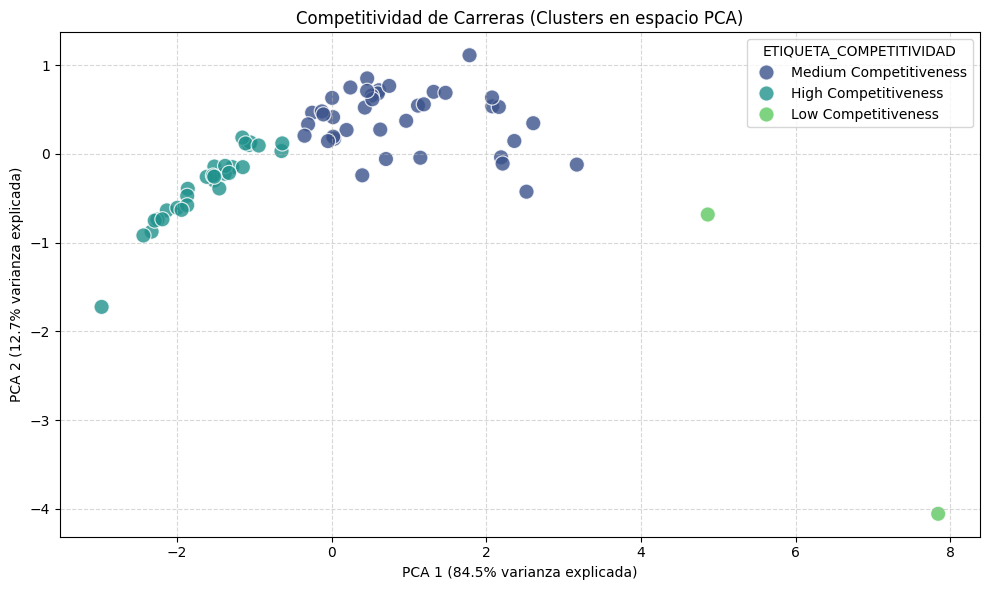

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 4. Visualización de clusters                     ║
# ╚══════════════════════════════════════════════════╝
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA y Visualización con varianza explicada
pca_vis = PCA(n_components=2, random_state=42)
X_pca = pca_vis.fit_transform(X_scaled)
explained_var = pca_vis.explained_variance_ratio_ * 100  # Porcentaje de varianza

# Asegura que df_vis incluya las etiquetas correctamente
df_vis = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=df_carreras_avg.index)
df_vis["ETIQUETA_COMPETITIVIDAD"] = df_carreras_avg["ETIQUETA_COMPETITIVIDAD"].values

# Varianza explicada
explained_var = pca_vis.explained_variance_ratio_ * 100

# Gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_vis,
    x="PCA1",
    y="PCA2",
    hue="ETIQUETA_COMPETITIVIDAD",  # Aquí debe ir bien asignado
    palette="viridis",
    s=120,
    alpha=0.8
)
plt.title("Competitividad de Carreras (Clusters en espacio PCA)")
plt.xlabel(f"PCA 1 ({explained_var[0]:.1f}% varianza explicada)")
plt.ylabel(f"PCA 2 ({explained_var[1]:.1f}% varianza explicada)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




En este paso se aplica **Análisis de Componentes Principales (PCA)** para reducir las variables multidimensionales utilizadas en el clustering a un espacio bidimensional, con el objetivo de facilitar la interpretación visual del agrupamiento de carreras según su competitividad.

---

Cada punto representa una **carrera**, proyectada en un espacio 2D construido a partir de las combinaciones lineales de las variables originales (`PUNTAJE_MINIMO`, `TASA_DEMANDA`, `TASA_ADMISION`, `RELACION_AS_AD`).
* El eje **PCA 1** explica la mayor parte de la varianza entre las carreras, seguido del eje **PCA 2**.
* Los puntos están **coloreados** según la **etiqueta de competitividad** asignada por el modelo K-Means:

  * 🟣 **Baja Competitividad**
  * 🔵 **Media Competitividad**
  * 🟢 **Alta Competitividad**

---


* Existe una **distribución clara y ordenada** de los grupos a lo largo del eje horizontal (PCA 1), que refleja diferencias estructurales entre carreras.
* Las carreras con **alta competitividad** tienden a ubicarse en un extremo del gráfico, mientras que las de **baja competitividad** aparecen bien separadas, generalmente más alejadas del resto, lo que indica un comportamiento muy distinto.
* La **concentración de media competitividad** en la zona central sugiere que muchas carreras comparten un perfil intermedio en cuanto a su nivel de exigencia y acceso.


Paso 5. Se utiliza un gráfico de cajas y bigotes (boxplot) para mostrar la distribución de cada variable dentro de cada grupo. Esto permite:

* Comparar cómo se comporta, por ejemplo, el puntaje mínimo o la tasa de admisión en cada nivel de competitividad.

* Observar si existen valores atípicos o solapamientos entre grupos.

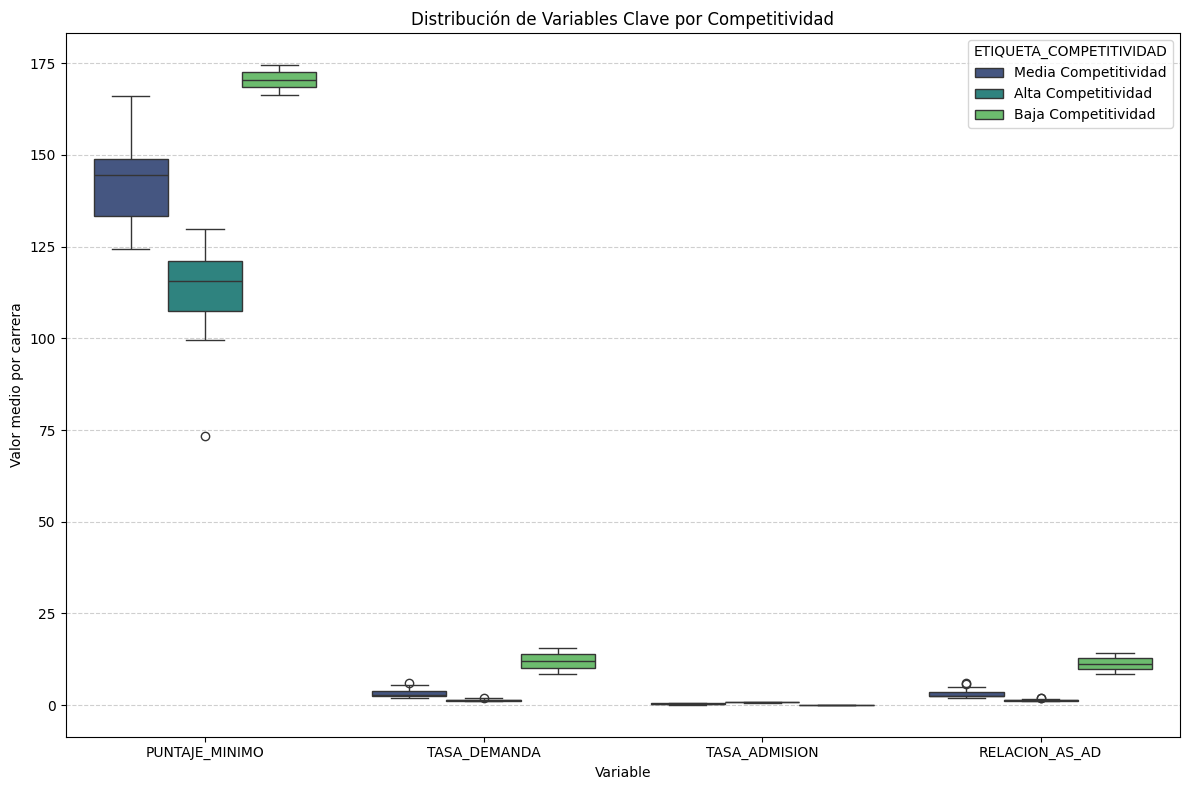

TIPO                                            CARRERA  \
0                                               ABOGADO   
1                            ABOGADO (SEMIESCOLARIZADO)   
2                                  INGENIERIA BIOMEDICA   
3                                      INGENIERIA CIVIL   
4                   INGENIERIA EN CIENCIA DE MATERIALES   
..                                                  ...   
66                            MEDICO CIRUJANO Y PARTERO   
67    TECNICO SUPERIOR UNIVERSITARIO EN EMERGENCIAS,...   
68    TECNICO SUPERIOR UNIVERSITARIO EN PROTESIS DENTAL   
69    TECNICO SUPERIOR UNIVERSITARIO EN RADIOLOGIA E...   
70    TECNICO SUPERIOR UNIVERSITARIO EN TERAPIA RESP...   

TIPO ETIQUETA_COMPETITIVIDAD  PUNTAJE_MINIMO  TASA_DEMANDA  TASA_ADMISION  \
0       Media Competitividad      144.698453      3.260478       0.324936   
1       Media Competitividad      130.682123      2.553702       0.431916   
2       Media Competitividad      166.202910      3.485404       0.312826   
3       Media Competitividad      155.886145      4.279240       0.243094   
4        Alta Competitividad      121.786474      1.249930       0.848571   
..                       ...             ...           ...            ...   
66       Baja Competitividad      174.564352      8.464882       0.126231   
67      Media Competitividad      125.659132      2.042438       0.515244   
68       Alta Competitividad      107.226581      1.265720       0.845232   
69      Media Competitividad      126.887055      2.428501       0.471828   
70       Alta Competitividad      105.283127      1.226610       0.849513   

TIPO  RELACION_AS_AD  
0           3.236452  
1           2.526114  
2           3.400751  
3           4.277187  
4           1.242623  
..               ...  
66          8.447981  
67          2.040253  
68          1.272419  
69          2.397174  
70          1.253311  

[71 rows x 6 columns]

In [ ]:
# ╔══════════════════════════════════════════════════╗
# ║ 5. Exploración de variables por cluster          ║
# ╚══════════════════════════════════════════════════╝
df_long = (
    df_carreras_avg
    .reset_index()
    .melt(
        id_vars=["CARRERA", "ETIQUETA_COMPETITIVIDAD"],
        value_vars=features_final,
        var_name="Variable",
        value_name="Valor"
    )
)

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_long,
    x="Variable",
    y="Valor",
    hue="ETIQUETA_COMPETITIVIDAD",
    palette="viridis"
)
plt.title("Distribución de Variables Clave por Competitividad")
plt.ylabel("Valor medio por carrera")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Tabla final
df_resultados = df_carreras_avg.reset_index()
display(df_resultados[["CARRERA", "ETIQUETA_COMPETITIVIDAD"] + features_final])


Este paso presenta un análisis visual y estadístico de cómo se comportan las variables que definen la competitividad en cada uno de los tres grupos detectados mediante clustering.


Se muestran **diagramas de caja (boxplots)** que reflejan la distribución de cuatro variables por grupo de competitividad:

  * `PUNTAJE_MINIMO`
  * `TASA_DEMANDA`
  * `TASA_ADMISION`
  * `RELACION_AS_AD`

Cada color representa un grupo:

  * 🟣 **Baja Competitividad**
  * 🔵 **Media Competitividad**
  * 🟢 **Alta Competitividad**

---

#### **1. Puntaje Mínimo**

* Las carreras **de baja competitividad** tienen el **puntaje mínimo más alto**, lo que puede parecer contradictorio, pero indica que estas carreras tienen pocos aspirantes y aún así exigen puntajes altos (probablemente por baja oferta o requisitos formales).
* Las **de alta competitividad** presentan puntajes mínimos **mucho más bajos**, lo que refleja su alto volumen de aspirantes, aunque con mayor margen de ingreso al ampliar cupos o bajar filtros.

*El puntaje mínimo no siempre refleja exigencia, sino dinámica entre demanda y cupo.*

---

#### **2. Tasa de Demanda**

* Las carreras de **alta competitividad** presentan **tasas de demanda más altas** (mediana cercana a 12), lo que indica mucha presión por ingresar.
* Las **de baja competitividad** tienen tasas de demanda muy bajas, muchas cercanas a 1 (es decir, un aspirante por cada plaza).

*Una tasa de demanda alta es el mejor indicador de carreras muy solicitadas.*

---

#### **3. Tasa de Admisión**

* Las carreras **más competitivas** tienen **tasas de admisión muy bajas** (≈0.15), lo que indica que solo un pequeño porcentaje de aspirantes es admitido.
* En cambio, las de **baja competitividad** admiten a casi todos los aspirantes (≈0.85), y las **medias** se ubican en un punto intermedio (≈0.32–0.43).

*La tasa de admisión baja indica fuerte filtro de acceso, típico de programas de alta demanda.*

---

#### **4. Relación Aspirantes / Admitidos**

* La relación más alta se presenta en el grupo **de alta competitividad** (valores mayores a 10).
* En el grupo **de baja competitividad**, esta relación es cercana a 1, lo que implica que prácticamente todos los aspirantes son aceptados.

*Esta variable amplifica la diferencia entre cuántos aspiran y cuántos son admitidos, sirviendo como síntesis de presión.*


##Detección de Anomalías en la Demanda y Admisión

Detectar registros atípicos entre las carreras de la Universidad de Guadalajara, considerando su comportamiento histórico en demanda, admisión y nivel de exigencia. Esto permite identificar eventos fuera de lo normal, posibles errores de captura, o transformaciones institucionales significativas.

Modelos utilizados:
* Isolation Forest (Bosque de Aislamiento)
* Local Outlier Factor (LOF)

Ambos algoritmos permiten detectar puntos que se comportan de manera estadísticamente diferente al resto de los datos, sin necesidad de etiquetas previas.

Variables utilizadas como entrada:
* ASPIRANTES
+ ADMITIDOS
* PUNTAJE_MINIMO
* TASA_DEMANDA
* TASA_ADMISION

(Todas calculadas como promedios por carrera, desde df_carreras_avg)

Resultado esperado:
* Etiquetar automáticamente cada carrera como:
* Normal (comportamiento esperado)
* Anómala (comportamiento fuera de lo común)

Visualización de las anomalías en el espacio PCA (reducción de dimensiones), para facilitar su interpretación.


---



En esta etapa se construye la matriz de características que alimentará a los modelos de detección.
Se seleccionan las variables numéricas más relevantes para caracterizar la competitividad y el comportamiento histórico de cada carrera:

* ASPIRANTES,
* ADMITIDOS,
* PUNTAJE_MINIMO,
* TASA_DEMANDA,
* TASA_ADMISION

(todas como promedios por carrera).

Posteriormente, los datos son normalizados utilizando StandardScaler, lo que transforma cada variable para que tenga media cero y desviación estándar uno.
Este paso es esencial, ya que evita que variables con mayor escala (por ejemplo, número de aspirantes) dominen el análisis frente a otras igualmente importantes, como la tasa de admisión.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Variables clave ya procesadas en df_carreras_avg (por carrera promedio)
features_anomalia = ["PUNTAJE_MINIMO", "TASA_DEMANDA", "TASA_ADMISION", "RELACION_AS_AD"]

df_anomalia = df_carreras_avg[features_anomalia].dropna().copy()

# Escalado
scaler_anomalia = StandardScaler()
X_scaled_anomalia = scaler_anomalia.fit_transform(df_anomalia)



Se entrena un modelo de Isolation Forest, un algoritmo basado en árboles binarios aleatorios que está diseñado específicamente para identificar outliers en datos multivariados. Su principio fundamental es que los datos anómalos tienden a ser más fáciles de aislar: requieren menos divisiones (splits) para separarlos del resto del conjunto en un árbol.


El modelo genera múltiples árboles de aislamiento y mide para cada punto la profundidad promedio necesaria para aislarlo. Si un dato es muy diferente de los demás, se necesitarán menos divisiones para aislarlo (es decir, estará más cerca de la raíz del árbol), lo cual se traduce en una profundidad baja.

* Si un punto tiene profundidad promedio baja → es considerado un outlier.

* Si tiene profundidad alta → es un dato normal, ya que está bien integrado en la estructura general de los datos.

Al final, el modelo etiqueta cada observación con:

* 1: comportamiento normal (difícil de aislar),



---



En esta etapa se aplica el modelo Local Outlier Factor (LOF) para complementar la detección realizada con Isolation Forest. A diferencia del enfoque global del paso anterior, LOF identifica anomalías locales, es decir, observaciones que presentan una densidad anormalmente baja comparada con sus vecinas más cercanas.

El modelo compara cada punto con su entorno local (por defecto, los 20 vecinos más cercanos) y calcula una relación de densidades. Si una carrera se encuentra en una zona donde sus características se alejan considerablemente de sus vecinas, su puntuación LOF será alta (desviación).

* LOF ≈ 1 → comportamiento normal (densidad similar a su entorno)

* LOF ≫ 1 → posible outlier (densidad mucho menor a la esperada)

El modelo clasifica con -1 a los registros que se desvían significativamente (outliers), y con 1 a los normales.

*Esto permite detectar carreras que, aunque no sean extremas en términos globales, sí tienen un comportamiento atípico dentro de su contexto inmediato (por ejemplo, carreras que tienen una tasa de admisión alta a pesar de una demanda considerable).*

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Modelo Isolation Forest
model_iforest = IsolationForest(contamination='auto', random_state=42)
df_anomalia["ISO_ANOMALY"] = model_iforest.fit_predict(X_scaled_anomalia)  # -1 = anómalo

# Modelo LOF
model_lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
df_anomalia["LOF_ANOMALY"] = model_lof.fit_predict(X_scaled_anomalia)  # -1 = anómalo

# Anomalía combinada (por lo menos uno)
df_anomalia["ANOMALIA"] = (df_anomalia["ISO_ANOMALY"] == -1) | (df_anomalia["LOF_ANOMALY"] == -1)



Para incrementar la robustez del análisis, se combinan los resultados de ambos modelos.
Una carrera es clasificada como anómala si al menos uno de los dos algoritmos la detectó como tal (-1).

Este enfoque de combinación tiene dos beneficios clave:

1. Reducción de falsos negativos: se detectan más casos relevantes.
2. Mayor confiabilidad: se consideran tanto outliers globales como locales.

El resultado final es una nueva columna booleana (ANOMALIA) que indica si una carrera debe ser examinada con atención.


---



La tabla presenta las 11 carreras que fueron clasificadas como anómalas por al menos uno de los modelos (ISO_ANOMALY = -1 o LOF_ANOMALY = -1). Para cada una se incluyen sus valores promedio en las variables clave:

* PUNTAJE_MINIMO
* TASA_DEMANDA
* TASA_ADMISION
* RELACION_AS_AD

Además, se indica qué modelo detectó la anomalía:

* "ISO_ANOMALY" = -1 → fue marcada por Isolation Forest
* "LOF_ANOMALY" = -1 → fue marcada por LOF
* Si ambos son -1 → alta concordancia entre modelos, anomalía robusta

Ejemplos destacados:

LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGÍAS INTERACTIVAS:
Presenta una tasa de demanda muy elevada (15.69) con una tasa de admisión baja (0.14) y una relación aspirantes/admitidos extremadamente alta (14.24). Ambos modelos coinciden en clasificarla como anómala.

LICENCIATURA EN ENFERMERÍA (NIVELACIÓN) y GEOGRAFÍA:
Son detectadas por LOF como outliers a pesar de tener tasas de demanda bajas, posiblemente por su tasa de admisión inusualmente alta (~0.97), lo que contrasta con el resto del conjunto.

MEDICO CIRUJANO Y PARTERO:
Combinación extrema de alta demanda (8.32), baja tasa de admisión (0.15) y alta relación aspirantes/admitidos (8.54). Aislada rápidamente por Isolation Forest y también marcada por LOF.


---


In [ ]:
anomalas = df_anomalia[df_anomalia["ANOMALIA"]].copy()
print(f"Total de carreras con comportamiento anómalo: {anomalas.shape[0]}")
display(anomalas[features_anomalia + ["ISO_ANOMALY", "LOF_ANOMALY"]])

Total de carreras con comportamiento anómalo: 11


TIPO                                                PUNTAJE_MINIMO  \
CARRERA                                                              
INGENIERIA BIOMEDICA                                    166.202910   
LICENCIATURA EN ARQUITECTURA                            159.304739   
LICENCIATURA EN CRIMINOLOGIA                            133.380943   
LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGIAS INTE...      166.449492   
LICENCIATURA EN ENFERMERIA (NIVELACION)                  73.322010   
LICENCIATURA EN GEOGRAFIA                               100.146910   
LICENCIATURA EN NUTRICION                               147.105803   
LICENCIATURA EN PSICOLOGIA                              158.054523   
LICENCIATURA EN TERAPIA FISICA                          144.470726   
LICENCIATURA EN TRABAJO SOCIAL (MODALIDAD ESCOL...      124.384932   
MEDICO CIRUJANO Y PARTERO                               174.564352   

TIPO                                                TASA_DEMANDA  \
CARRERA                                                            
INGENIERIA BIOMEDICA                                    3.485404   
LICENCIATURA EN ARQUITECTURA                            5.086740   
LICENCIATURA EN CRIMINOLOGIA                            3.839206   
LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGIAS INTE...     15.691190   
LICENCIATURA EN ENFERMERIA (NIVELACION)                 1.200211   
LICENCIATURA EN GEOGRAFIA                               1.026161   
LICENCIATURA EN NUTRICION                               5.101558   
LICENCIATURA EN PSICOLOGIA                              6.065356   
LICENCIATURA EN TERAPIA FISICA                          5.599834   
LICENCIATURA EN TRABAJO SOCIAL (MODALIDAD ESCOL...      3.203381   
MEDICO CIRUJANO Y PARTERO                               8.464882   

TIPO                                                TASA_ADMISION  \
CARRERA                                                             
INGENIERIA BIOMEDICA                                     0.312826   
LICENCIATURA EN ARQUITECTURA                             0.207667   
LICENCIATURA EN CRIMINOLOGIA                             0.310891   
LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGIAS INTE...       0.144410   
LICENCIATURA EN ENFERMERIA (NIVELACION)                  0.944589   
LICENCIATURA EN GEOGRAFIA                                0.978030   
LICENCIATURA EN NUTRICION                                0.254332   
LICENCIATURA EN PSICOLOGIA                               0.170791   
LICENCIATURA EN TERAPIA FISICA                           0.222914   
LICENCIATURA EN TRABAJO SOCIAL (MODALIDAD ESCOL...       0.425825   
MEDICO CIRUJANO Y PARTERO                                0.126231   

TIPO                                                RELACION_AS_AD  \
CARRERA                                                              
INGENIERIA BIOMEDICA                                      3.400751   
LICENCIATURA EN ARQUITECTURA                              4.968320   
LICENCIATURA EN CRIMINOLOGIA                              3.823622   
LICENCIATURA EN DISEÑO, ARTE Y TECNOLOGIAS INTE...       14.244898   
LICENCIATURA EN ENFERMERIA (NIVELACION)                   1.157385   
LICENCIATURA EN GEOGRAFIA                                 1.035681   
LICENCIATURA EN NUTRICION                                 4.985710   
LICENCIATURA EN PSICOLOGIA                                6.079470   
LICENCIATURA EN TERAPIA FISICA                            5.733709   
LICENCIATURA EN TRABAJO SOCIAL (MODALIDAD ESCOL...        3.285907   
MEDICO CIRUJANO Y PARTERO                                 8.447981   

TIPO                                                ISO_ANOMALY  LOF_ANOMALY  
CARRERA                                                                       
INGENIERIA BIOMEDICA                                         -1            1  
LICENCIATURA EN ARQUITECTURA                                 -1            1  
LICENCIATURA EN CRIMINOLOGIA                                 -1            1  


Para facilitar la interpretación visual de los resultados, se aplica Análisis de Componentes Principales (PCA), que permite reducir las múltiples dimensiones del análisis a solo dos (PCA 1 y PCA 2).

Cada carrera es proyectada como un punto en el plano 2D, y su color representa si fue o no clasificada como anómala.

* Los puntos grises indican comportamiento normal.

* Los puntos rojos representan carreras con patrones atípicos, detectadas por al menos uno de los modelos.

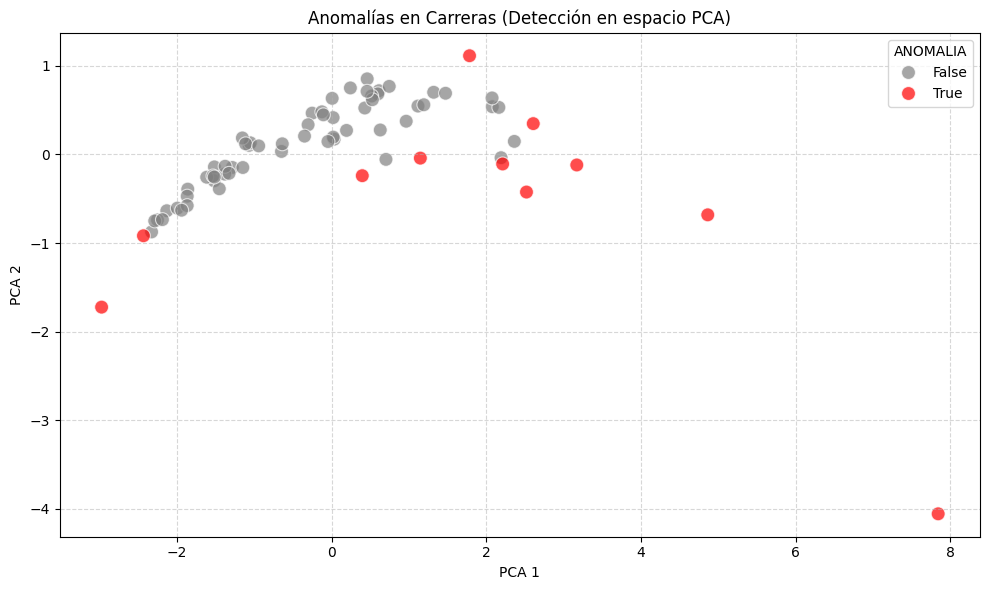

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar PCA si no se ha hecho antes
pca_anom = PCA(n_components=2, random_state=42)
X_pca_anom = pca_anom.fit_transform(X_scaled_anomalia)

# DataFrame visual
df_anomalia_vis = df_anomalia.copy()
df_anomalia_vis[["PCA1", "PCA2"]] = X_pca_anom

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_anomalia_vis,
    x="PCA1", y="PCA2",
    hue="ANOMALIA",
    palette={True: "red", False: "gray"},
    alpha=0.7,
    s=100
)
plt.title("Anomalías en Carreras (Detección en espacio PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show() # Muestra la figura (esto va DESPUÉS de guardarla)



Cada punto en el plano representa una **carrera universitaria**, descrita por sus valores estandarizados de:

  * Puntaje mínimo,
  * Tasa de demanda,
  * Tasa de admisión,
  * Relación aspirantes/admitidos.

Los dos ejes (`PCA 1` y `PCA 2`) son combinaciones lineales de estas variables y capturan la mayor parte de la **variabilidad del conjunto de datos**.

* El **color de cada punto** indica si fue detectado como **anómalo (`True`) o normal (`False`)**:

  * 🔴 **Rojo**: carrera identificada como anómala (por Isolation Forest o LOF).
  * ⚫ **Gris**: carrera con comportamiento esperado (normal).

---

Las carreras anómalas (rojas) tienden a ubicarse en regiones **más dispersas o periféricas** del espacio PCA, lo que indica que sus combinaciones de características son poco comunes respecto al resto del conjunto.

Algunas anomalías aparecen **aisladas visualmente** del resto del grupo, reforzando la validez de su detección.

También se observan **algunas anomalías integradas visualmente** en el grupo general, lo cual es coherente con lo que detecta **LOF** (anomalías locales, no necesariamente globales).




In [ ]:
# Crear df_promedios desde el dataframe general ya cargado (df)
df_promedios = df.copy()

# Detectar columnas relevantes
cols_asp = [col for col in df_promedios.columns if 'AS' in col]
cols_adm = [col for col in df_promedios.columns if 'AD' in col]
cols_pm  = [col for col in df_promedios.columns if 'PM' in col]

# Calcular promedios por carrera
# Asegurar que todas las columnas relevantes sean numéricas
df_promedios[cols_asp] = df_promedios[cols_asp].apply(pd.to_numeric, errors='coerce')
df_promedios[cols_adm] = df_promedios[cols_adm].apply(pd.to_numeric, errors='coerce')
df_promedios[cols_pm]  = df_promedios[cols_pm].apply(pd.to_numeric, errors='coerce')

# Calcular promedios
df_promedios['ASPIRANTES_PROM'] = df_promedios[cols_asp].mean(axis=1, skipna=True)
df_promedios['ADMITIDOS_PROM']  = df_promedios[cols_adm].mean(axis=1, skipna=True)
df_promedios['PM_PROM']         = df_promedios[cols_pm].mean(axis=1, skipna=True)



In [ ]:
# Interfaz interactiva con ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de centros únicos
centros_disponibles = sorted(df_promedios["CU"].dropna().unique())

# Dropdown para seleccionar centro
dropdown_cu = widgets.Dropdown(
    options=centros_disponibles,
    value="CUCEI",
    description="Centro:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Función para graficar el top
def graficar_top_carreras(centro):
    clear_output(wait=True)
    display(dropdown_cu)

    df_centro = df_promedios[df_promedios["CU"] == centro][['CARRERA', 'ASPIRANTES_PROM', 'ADMITIDOS_PROM', 'PM_PROM']].dropna()

    # Top 10 para cada métrica
    top_asp = df_centro.sort_values(by='ASPIRANTES_PROM', ascending=False).head(10)
    top_adm = df_centro.sort_values(by='ADMITIDOS_PROM', ascending=False).head(10)
    top_pm  = df_centro.sort_values(by='PM_PROM', ascending=False).head(10)

    # Crear gráficas
    fig, axs = plt.subplots(1, 3, figsize=(18, 8))

    sns.barplot(data=top_asp, y='CARRERA', x='ASPIRANTES_PROM', ax=axs[0])
    axs[0].set_title(f"Aspirantes promedio en {centro}")

    sns.barplot(data=top_adm, y='CARRERA', x='ADMITIDOS_PROM', ax=axs[1])
    axs[1].set_title(f"Admitidos promedio en {centro}")

    sns.barplot(data=top_pm, y='CARRERA', x='PM_PROM', ax=axs[2])
    axs[2].set_title(f"Puntaje mínimo promedio en {centro}")

    plt.tight_layout()
    plt.show()

# Conectar dropdown con función
interactive_output = widgets.interactive_output(graficar_top_carreras, {'centro': dropdown_cu})

# Mostrar interfaz
display(dropdown_cu, interactive_output)



TraitError: Invalid selection: value not found